In [1]:
from __future__ import print_function
import os
import pickle

import numpy as np
import time
import datetime
from functools import reduce

from sklearn import svm, datasets
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import scipy.io
import scipy.integrate
from astropy.convolution import convolve, Box1DKernel

from matplotlib import pyplot as plt
import matplotlib.cm as cm

from matplotlib import rc
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.path import Path as mpath
from scipy.optimize import least_squares

import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.max_rows = 90

np.set_printoptions(threshold=np.nan)

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

###############
## COMPUTER ##
###############

laptop = False

In [2]:
def boxcar_width(x):
    return (np.ceil(x) // 2 * 2 + 1).astype(int)

In [3]:
# for data in the TowerX_M-DD-YY format...

# 0"TIMESTAMP"
# 1"RECORD"
# 2"AWS"
# 3"AWD"
# 4"SIG"
# 5"WSStdDev"
# 6"WSGust"
# 7"WSgst_TMx"
# 8"AvgWS2"
# 9"WS2StdDev"
# 10"WS2Gust"
# 11"WS2gst_TMx"
# 12"AvgWS3"
# 13"WS3StdDev"
# 14"WS3Gust"
# 15"WS3gst_TMx"
# 16"AvgAT"
# 17"AvgRH"
# 18"AvgDP"
# 19"AvgHIdx"
# 20"AvgLBP"
# 21"AvgSLBP"
# 22"AvgST"
# 23"AvgVW"
# 24"TotPrec"
# 25"AvgPZ"
# 26"LTemp"
# 27"Batt"
# 28"AvgPM0.3"
# 29"AvgPM0.5"
# 30"AvgPM0.7"
# 31"AvgPM1"
# 32"AvgPM2"
# 33"AvgPM3"
# 34"AvgPM5"
# 35"AvgPM10"
# 36"AvgFlow"
# 37"Alarm

s_2_d = 1/(60*60*24)

In [4]:
p10 = Path(os.getcwd()+'/Tower1/Tower1_7-17-15/Tower1_Avg10Min.dat')
p11 = Path(os.getcwd()+'/Tower1/Tower1_8-15-15/Tower1_Avg10Min_2015_08_15_08_15_22.dat')
p12 = Path(os.getcwd()+'/Tower1/Tower1_8-3-15/Tower1_Avg10Min_2015_08_03_12_20_02.dat')

p20 = Path(os.getcwd()+'/Tower2/Tower2_7-17-15/Tower2_Avg10Min.dat')
p21 = Path(os.getcwd()+'/Tower2/Tower2_8-15-15/Tower2_Avg10Min_2015_08_15_09_17_56.dat')
p22 = Path(os.getcwd()+'/Tower2/Tower2_8-3-15/Tower2_Avg10Min_2015_08_03_12_34_29.dat')

p30 = Path(os.getcwd()+'/Tower3/Tower3_7-17-15/Tower3_Avg10Min.dat')
p31 = Path(os.getcwd()+'/Tower3/Tower3_7-6-15/Tower3_Avg10Min.dat')
p32 = Path(os.getcwd()+'/Tower3/Tower3_8-15-15/Tower3_Avg10Min_2015_08_15_09_32_09.dat')

# 2nd file for twoer1 is weird, omit for now
path = [p10,p11,p20,p21,p22,p30,p31,p32]
towe = [1,1,2,2,2,3,3,3]

t1 = []
t2 = []
t3 = []

a1 = []
a2 = []
a3 = []

u01 = []
u11 = []
u21 = []
u02 = []
u12 = []
u22 = []
u03 = []
u13 = []
u23 = []

T1 = []
T2 = []
T3 = []

h1 = []
h2 = []
h3 = []

for i in range(0,np.shape(path)[0]):
    tempdata = pd.read_csv(path[i],header=1)
    if towe[i]==1:
        t1  = np.append(t1,tempdata.iloc[2:,0])
        a1  = np.append(a1,tempdata.iloc[2:,3])
        u01 = np.append(u01,tempdata.iloc[2:,12])
        u11 = np.append(u11,tempdata.iloc[2:,8])
        u21 = np.append(u21,tempdata.iloc[2:,2])
        T1  = np.append(T1,tempdata.iloc[2:,16])
    elif towe[i]==2:
        t2  = np.append(t2,tempdata.iloc[2:,0])
        a2  = np.append(a2,tempdata.iloc[2:,3])
        u02 = np.append(u02,tempdata.iloc[2:,12])
        u12 = np.append(u12,tempdata.iloc[2:,8])
        u22 = np.append(u22,tempdata.iloc[2:,2])
        T2  = np.append(T2,tempdata.iloc[2:,16])      
    elif towe[i]==3:
        t3  = np.append(t3,tempdata.iloc[2:,0])
        a3  = np.append(a3,tempdata.iloc[2:,3])
        u03 = np.append(u03,tempdata.iloc[2:,12])
        u13 = np.append(u13,tempdata.iloc[2:,8])
        u23 = np.append(u23,tempdata.iloc[2:,2])
        T3  = np.append(T3,tempdata.iloc[2:,16])
        
t1s = []
t2s = []
t3s = []

for i in t1:
    try:
        t1s.append(int(time.mktime(datetime.datetime.strptime(i,'%Y-%m-%d %H:%M:%S').timetuple())))
    except:
        #because it does 24:00:00 and datetime doesn't like that
        t1s.append(int(time.mktime(datetime.datetime.strptime(i[:-9],'%Y-%m-%d').timetuple())))

for i in t2:
    try:
        t2s.append(int(time.mktime(datetime.datetime.strptime(i,'%Y-%m-%d %H:%M:%S').timetuple())))
    except:
        #because it does 24:00:00 and datetime doesn't like that
        t2s.append(int(time.mktime(datetime.datetime.strptime(i[:-9],'%Y-%m-%d').timetuple())))
        
for i in t3:
    try:
        t3s.append(int(time.mktime(datetime.datetime.strptime(i,'%Y-%m-%d %H:%M:%S').timetuple())))
    except:
        #because it does 24:00:00 and datetime doesn't like that
        t3s.append(int(time.mktime(datetime.datetime.strptime(i[:-9],'%Y-%m-%d').timetuple())))


In [5]:
t1s = np.asarray(t1s)
t2s = np.asarray(t2s)
t3s = np.asarray(t3s)

a1 = np.asarray(a1,dtype=np.float)
a2 = np.asarray(a2,dtype=np.float)
a3 = np.asarray(a3,dtype=np.float)

u01 = np.asarray(u01,dtype=np.float)
u11 = np.asarray(u11,dtype=np.float)
u21 = np.asarray(u21,dtype=np.float)
u02 = np.asarray(u02,dtype=np.float)
u12 = np.asarray(u12,dtype=np.float)
u22 = np.asarray(u22,dtype=np.float)
u03 = np.asarray(u03,dtype=np.float)
u13 = np.asarray(u13,dtype=np.float)
u23 = np.asarray(u23,dtype=np.float)

T1 = np.asarray(T1,dtype=np.float)
T2 = np.asarray(T2,dtype=np.float)
T3 = np.asarray(T3,dtype=np.float)

In [6]:
s_2_d = 1/(60*60*24)

t1d = t1s*s_2_d
t2d = t2s*s_2_d
t3d = t3s*s_2_d

In [7]:
tsc = reduce(np.intersect1d, (t1s, t2s, t3s))

a1c = []
a2c = []
a3c = []

u01c = []
u02c = []
u03c = []
u11c = []
u12c = []
u13c = []
u21c = []
u22c = []
u23c = []

T1c = []
T2c = []
T3c = []

for i in range(0,np.shape(tsc)[0]):
    a1c = np.append(a1c,a1[t1s==tsc[i]][0])
    a2c = np.append(a2c,a2[t2s==tsc[i]][0])
    a3c = np.append(a3c,a3[t3s==tsc[i]][0])
    
    u01c = np.append(u01c,u01[t1s==tsc[i]][0])
    u02c = np.append(u02c,u02[t2s==tsc[i]][0])
    u03c = np.append(u03c,u03[t3s==tsc[i]][0])
    u11c = np.append(u11c,u11[t1s==tsc[i]][0])
    u12c = np.append(u12c,u12[t2s==tsc[i]][0])
    u13c = np.append(u13c,u13[t3s==tsc[i]][0])
    u21c = np.append(u21c,u21[t1s==tsc[i]][0])
    u22c = np.append(u22c,u22[t2s==tsc[i]][0])
    u23c = np.append(u23c,u23[t3s==tsc[i]][0])
    
    T1c = np.append(T1c,T1[t1s==tsc[i]][0])
    T2c = np.append(T2c,T2[t2s==tsc[i]][0])
    T3c = np.append(T3c,T3[t3s==tsc[i]][0])

In [8]:
adunes = 247.5 #be more rigorous with met tower locations later
adelta = 15

u01a = []
u02a = []
u03a = []
u11a = []
u12a = []
u13a = []
u21a = []
u22a = []
u23a = []

a1a = []
a2a = []
a3a = []

#change this to only be aligned by upwind

for i in range(0,np.shape(tsc)[0]):
#     if (a1c[i]<adunes+adelta) & (a1c[i]>adunes-adelta) & (a2c[i]<adunes+adelta) & (a2c[i]>adunes-adelta) & (a3c[i]<adunes+adelta) & (a3c[i]>adunes-adelta):
    if (a1c[i]<adunes+adelta) & (a1c[i]>adunes-adelta):
        u01a = np.append(u01a,u01c[i])
        u02a = np.append(u02a,u02c[i])
        u03a = np.append(u03a,u03c[i])
        u11a = np.append(u11a,u11c[i])
        u12a = np.append(u12a,u12c[i])
        u13a = np.append(u13a,u13c[i])
        u21a = np.append(u21a,u21c[i])
        u22a = np.append(u22a,u22c[i])
        u23a = np.append(u23a,u23c[i])
        
        a1a = np.append(a1a,a1c[i])
        a2a = np.append(a2a,a2c[i])
        a3a = np.append(a3a,a3c[i])

In [9]:
kap = 0.38
z = np.asarray([2,5,10])

u1c = np.asarray([u01c,u11c,u21c])
u1zc = np.polyfit(np.log(z), u1c,deg=1)
us1c = u1zc[0]*kap
zn1c = np.exp(-u1zc[0]*u1zc[1])

u2c = np.asarray([u02c,u12c,u22c])
u2zc = np.polyfit(np.log(z), u2c,deg=1)
us2c = u2zc[0]*kap
zn2c = np.exp(-u2zc[0]*u2zc[1])

u3c = np.asarray([u03c,u13c,u23c])
u3zc = np.polyfit(np.log(z), u3c,deg=1)
us3c = u3zc[0]*kap
zn3c = np.exp(-u3zc[0]*u3zc[1])

In [10]:
kap = 0.38
z = np.asarray([2,5,10])

u1a = np.asarray([u01a,u11a,u21a])
u1za = np.polyfit(np.log(z), u1a,deg=1)
us1a = u1za[0]*kap
zn1a = np.exp(-u1za[0]*u1za[1])

u2a = np.asarray([u02a,u12a,u22a])
u2za = np.polyfit(np.log(z), u2a,deg=1)
us2a = u2za[0]*kap
zn2a = np.exp(-u2za[0]*u2za[1])

u3a = np.asarray([u03a,u13a,u23a])
u3za = np.polyfit(np.log(z), u3a,deg=1)
us3a = u3za[0]*kap
zn3a = np.exp(-u3za[0]*u3za[1])

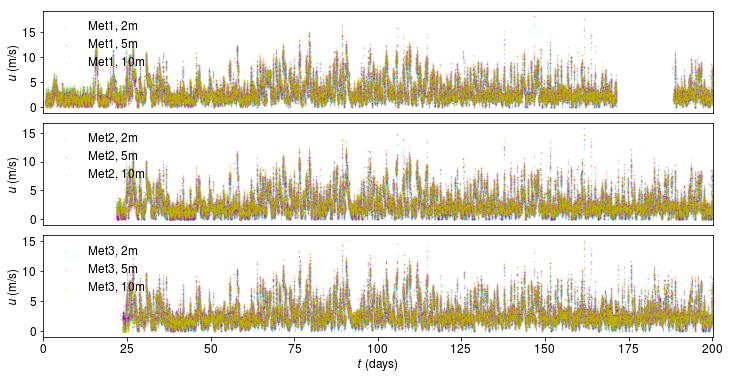

In [11]:
S = 1
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = -45
v6 = 45

lpu1 = 0
hpu1 = 25

tdmin = np.min([np.min(t1d),np.min(t2d),np.min(t3d)])
tdmax = np.max([np.max(t1d),np.max(t2d),np.max(t3d)])

fig = plt.gcf()

ax1 = plt.subplot(311)

sc = ax1.scatter(t1d-tdmin,u01,s=S,c='c',lw=LW,alpha=A,label='Met1, 2m')
sc = ax1.scatter(t1d-tdmin,u11,s=S,c='m',lw=LW,alpha=A,label='Met1, 5m')
sc = ax1.scatter(t1d-tdmin,u21,s=S,c='y',lw=LW,alpha=A,label='Met1, 10m')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_ylabel('$u$ (m/s)',fontsize=fs)

plt.xticks([],[])

plt.xlim(0,tdmax-tdmin)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax2 = plt.subplot(312)

sc = ax2.scatter(t2d-tdmin,u02,s=S,c='c',lw=LW,alpha=A,label='Met2, 2m')
sc = ax2.scatter(t2d-tdmin,u12,s=S,c='m',lw=LW,alpha=A,label='Met2, 5m')
sc = ax2.scatter(t2d-tdmin,u22,s=S,c='y',lw=LW,alpha=A,label='Met2, 10m')

ax2.legend(loc=2,frameon=False,fontsize=fs)

ax2.set_ylabel('$u$ (m/s)',fontsize=fs)
plt.xticks([],[])

plt.xlim(0,tdmax-tdmin)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax3 = plt.subplot(313)

sc = ax3.scatter(t3d-tdmin,u03,s=S,c='c',lw=LW,alpha=A,label='Met3, 2m')
sc = ax3.scatter(t3d-tdmin,u13,s=S,c='m',lw=LW,alpha=A,label='Met3, 5m')
sc = ax3.scatter(t3d-tdmin,u23,s=S,c='y',lw=LW,alpha=A,label='Met3, 10m')

ax3.legend(loc=2,frameon=False,fontsize=fs)

ax3.set_ylabel('$u$ (m/s)',fontsize=fs)
ax3.set_xlabel('$t$ (days)',fontsize=fs)

plt.xlim(0,tdmax-tdmin)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

fig.subplots_adjust(hspace=0.1)

fig.set_size_inches(12, 6, forward=True)
# plt.savefig('some_name80.png', bbox_inches='tight',dpi=300)

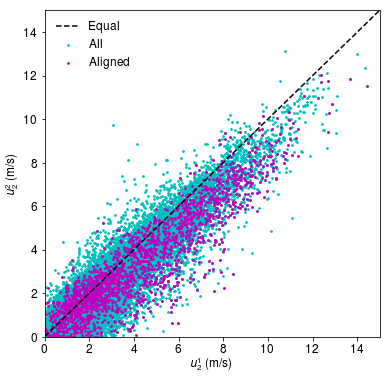

In [12]:
S = 3
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = -45
v6 = 45

lpu1 = 0
hpu1 = 25

fig = plt.gcf()

ax1 = plt.subplot(111)

sc = ax1.scatter(u01c,u02c,s=S,c='c',label='All')
sc = ax1.scatter(u01a,u02a,s=S,c='m',label='Aligned')
sc1 = ax1.plot([0,15],[0,15],'--',c='k',label='Equal')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_xlabel('$u_{2}^{1}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{2}^{2}$ (m/s)',fontsize=fs)

plt.xlim(0,15)
plt.ylim(0,15)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.2)

fig.set_size_inches(6, 6, forward=True)
# plt.savefig('some_name80.png', bbox_inches='tight',dpi=300)

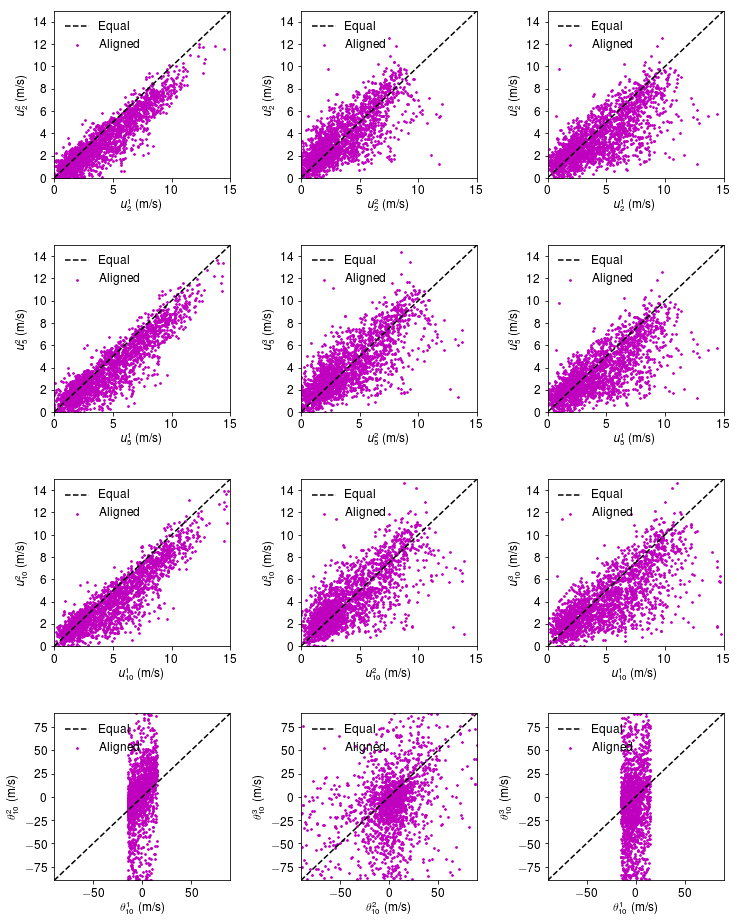

In [13]:
S = 3
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = -45
v6 = 45

lpu1 = 0
hpu1 = 25

fig = plt.gcf()

ax1 = plt.subplot(431)

sc = ax1.scatter(u01a,u02a,s=S,c='m',label='Aligned')
sc1 = ax1.plot([0,15],[0,15],'--',c='k',label='Equal')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_xlabel('$u_{2}^{1}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{2}^{2}$ (m/s)',fontsize=fs)

plt.xlim(0,15)
plt.ylim(0,15)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(432)

sc = ax1.scatter(u02a,u03a,s=S,c='m',label='Aligned')
sc1 = ax1.plot([0,15],[0,15],'--',c='k',label='Equal')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_xlabel('$u_{2}^{2}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{2}^{3}$ (m/s)',fontsize=fs)

plt.xlim(0,15)
plt.ylim(0,15)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(433)

sc = ax1.scatter(u01a,u03a,s=S,c='m',label='Aligned')
sc1 = ax1.plot([0,15],[0,15],'--',c='k',label='Equal')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_xlabel('$u_{2}^{1}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{2}^{3}$ (m/s)',fontsize=fs)

plt.xlim(0,15)
plt.ylim(0,15)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(434)

sc = ax1.scatter(u11a,u12a,s=S,c='m',label='Aligned')
sc1 = ax1.plot([0,15],[0,15],'--',c='k',label='Equal')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_xlabel('$u_{5}^{1}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{5}^{2}$ (m/s)',fontsize=fs)

plt.xlim(0,15)
plt.ylim(0,15)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(435)

sc = ax1.scatter(u12a,u13a,s=S,c='m',label='Aligned')
sc1 = ax1.plot([0,15],[0,15],'--',c='k',label='Equal')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_xlabel('$u_{5}^{2}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{5}^{3}$ (m/s)',fontsize=fs)

plt.xlim(0,15)
plt.ylim(0,15)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(436)

sc = ax1.scatter(u01a,u03a,s=S,c='m',label='Aligned')
sc1 = ax1.plot([0,15],[0,15],'--',c='k',label='Equal')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_xlabel('$u_{5}^{1}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{5}^{3}$ (m/s)',fontsize=fs)

plt.xlim(0,15)
plt.ylim(0,15)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(437)

sc = ax1.scatter(u21a,u22a,s=S,c='m',label='Aligned')
sc1 = ax1.plot([0,15],[0,15],'--',c='k',label='Equal')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_xlabel('$u_{10}^{1}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{10}^{2}$ (m/s)',fontsize=fs)

plt.xlim(0,15)
plt.ylim(0,15)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(438)

sc = ax1.scatter(u22a,u23a,s=S,c='m',label='Aligned')
sc1 = ax1.plot([0,15],[0,15],'--',c='k',label='Equal')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_xlabel('$u_{10}^{2}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{10}^{3}$ (m/s)',fontsize=fs)

plt.xlim(0,15)
plt.ylim(0,15)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(439)

sc = ax1.scatter(u21a,u23a,s=S,c='m',label='Aligned')
sc1 = ax1.plot([0,15],[0,15],'--',c='k',label='Equal')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_xlabel('$u_{10}^{1}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{10}^{3}$ (m/s)',fontsize=fs)

plt.xlim(0,15)
plt.ylim(0,15)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(4,3,10)

sc = ax1.scatter(a1a-adunes,a2a-adunes,s=S,c='m',label='Aligned')
sc1 = ax1.plot([-90,90],[-90,90],'--',c='k',label='Equal')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_xlabel('$\\theta_{10}^{1}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$\\theta_{10}^{2}$ (m/s)',fontsize=fs)

plt.xlim(-90,90)
plt.ylim(-90,90)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(4,3,11)

sc = ax1.scatter(a2a-adunes,a3a-adunes,s=S,c='m',label='Aligned')
sc1 = ax1.plot([-90,90],[-90,90],'--',c='k',label='Equal')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_xlabel('$\\theta_{10}^{2}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$\\theta_{10}^{3}$ (m/s)',fontsize=fs)

plt.xlim(-90,90)
plt.ylim(-90,90)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(4,3,12)

sc = ax1.scatter(a1a-adunes,a3a-adunes,s=S,c='m',label='Aligned')
sc1 = ax1.plot([-90,90],[-90,90],'--',c='k',label='Equal')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_xlabel('$\\theta_{10}^{1}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$\\theta_{10}^{3}$ (m/s)',fontsize=fs)

plt.xlim(-90,90)
plt.ylim(-90,90)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

fig.set_size_inches(12, 16, forward=True)
plt.savefig('some_name0.png', bbox_inches='tight',dpi=300)

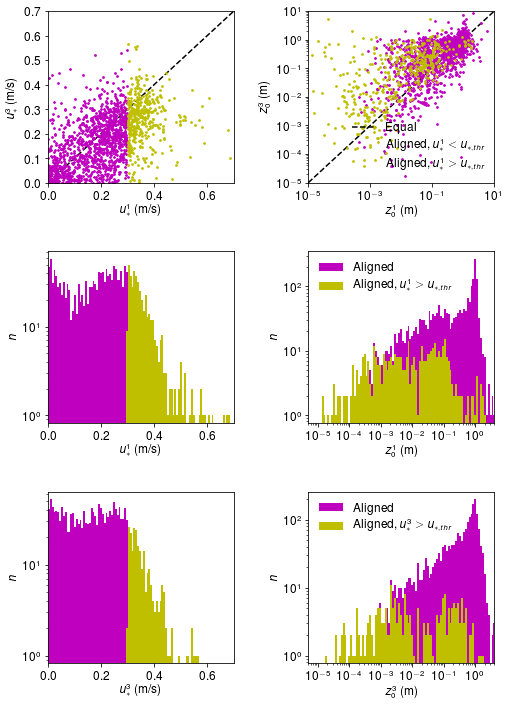

In [14]:
S = 3
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = -45
v6 = 45

lpu1 = 0
hpu1 = 25

usthr = 0.3
usmax = 0.7
znmax = 10
znmin = 10**-5

fig = plt.gcf()

ax1 = plt.subplot(321)

sc = ax1.scatter(us1a[us1a<=usthr],us3a[us1a<=usthr],s=S,c='m',label='Aligned, $u_{*}^{1}<u_{*,thr}$')
sc = ax1.scatter(us1a[us1a>usthr],us3a[us1a>usthr],s=S,c='y',label='Aligned, $u_{*}^{1}>u_{*,thr}$')
sc1 = ax1.plot([0,usmax],[0,usmax],'--',c='k',label='Equal',zorder=-1)


ax1.set_xlabel('$u_{*}^{1}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{*}^{3}$ (m/s)',fontsize=fs)

plt.xlim(0,usmax)
plt.ylim(0,usmax)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(322)

sc = ax1.scatter(zn1a[us1a<=usthr],zn3a[us1a<=usthr],s=S,c='m',label='Aligned, $u_{*}^{1}<u_{*,thr}$')
sc = ax1.scatter(zn1a[us1a>usthr],zn3a[us1a>usthr],s=S,c='y',label='Aligned, $u_{*}^{1}>u_{*,thr}$')
sc1 = ax1.plot([znmin,znmax],[znmin,znmax],'--',c='k',label='Equal',zorder=-1)

ax1.legend(loc=0,frameon=False,fontsize=fs)

ax1.set_xlabel('$z_{0}^{1}$ (m)',fontsize=fs)
ax1.set_ylabel('$z_{0}^{3}$ (m)',fontsize=fs)

plt.xlim(znmin,znmax)
plt.ylim(znmin,znmax)

ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(323)

t1 = ax1.hist(us1a,bins=100,range=[0,usmax],color='m',log=True,label='Aligned')
t1 = ax1.hist(us1a[us1a>usthr],bins=100,range=[0,usmax],color='y',log=True,label='Aligned, $u_{*}^{1}>u_{*,thr}$')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(0,usmax)

ax1.set_xlabel('$u_{*}^{1}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)


fig.subplots_adjust(wspace=0.4)
fig.subplots_adjust(hspace=0.4)

ax1 = plt.subplot(324)

t1 = ax1.hist(zn1a,bins=np.logspace(-5,1,100),color='m',log=True,label='Aligned')
t1 = ax1.hist(zn1a[us1a>usthr],bins=np.logspace(-5,1,100),color='y',log=True,label='Aligned, $u_{*}^{1}>u_{*,thr}$')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1.set_xscale('log')

plt.xlim(0,4)

ax1.set_xlabel('$z_{0}^{1}$ (m)',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1.legend(loc=0,frameon=False,fontsize=fs)

ax1 = plt.subplot(325)

t1 = ax1.hist(us3a,bins=100,range=[0,usmax],color='m',log=True,label='Aligned')
t1 = ax1.hist(us3a[us3a>usthr],bins=100,range=[0,usmax],color='y',log=True,label='Aligned, $u_{*}^{3}>u_{*,thr}$')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(0,usmax)

ax1.set_xlabel('$u_{*}^{3}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)


fig.subplots_adjust(wspace=0.4)
fig.subplots_adjust(hspace=0.4)

ax1 = plt.subplot(326)

t1 = ax1.hist(zn3a,bins=np.logspace(-5,1,100),color='m',log=True,label='Aligned')
t1 = ax1.hist(zn3a[us3a>usthr],bins=np.logspace(-5,1,100),color='y',log=True,label='Aligned, $u_{*}^{3}>u_{*,thr}$')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1.set_xscale('log')

plt.xlim(0,4)

ax1.set_xlabel('$z_{0}^{3}$ (m)',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1.legend(loc=0,frameon=False,fontsize=fs)

fig.subplots_adjust(wspace=0.4)
fig.subplots_adjust(hspace=0.4)

fig.set_size_inches(8,12, forward=True)
# plt.savefig('some_name80.png', bbox_inches='tight',dpi=300)

In [15]:
us1cr = us1c[(us1c>0)&(us2c>0)&(us3c>0)]
us2cr = us2c[(us1c>0)&(us2c>0)&(us3c>0)]
us3cr = us3c[(us1c>0)&(us2c>0)&(us3c>0)]

zn1cr = zn1c[(us1c>0)&(us2c>0)&(us3c>0)]
zn2cr = zn2c[(us1c>0)&(us2c>0)&(us3c>0)]
zn3cr = zn3c[(us1c>0)&(us2c>0)&(us3c>0)]

us1ar = us1a[(us1a>0)&(us2a>0)&(us3a>0)]
us2ar = us2a[(us1a>0)&(us2a>0)&(us3a>0)]
us3ar = us3a[(us1a>0)&(us2a>0)&(us3a>0)]

zn1ar = zn1a[(us1a>0)&(us2a>0)&(us3a>0)]
zn2ar = zn2a[(us1a>0)&(us2a>0)&(us3a>0)]
zn3ar = zn3a[(us1a>0)&(us2a>0)&(us3a>0)]

In [16]:
ausrescr = np.arctan2(us1cr-us2cr,us1cr-us3cr)
aznrescr = np.arctan2(zn1cr-zn2cr,zn1cr-zn3cr)

ausresar = np.arctan2(us1ar-us2ar,us1ar-us3ar)
aznresar = np.arctan2(zn1ar-zn2ar,zn1ar-zn3ar)

au0resc = np.arctan2(u01c-u02c,u01c-u03c)
au0resa = np.arctan2(u01a-u02a,u01a-u03a)
au1resc = np.arctan2(u11c-u12c,u11c-u13c)
au1resa = np.arctan2(u11a-u12a,u11a-u13a)
au2resc = np.arctan2(u21c-u22c,u21c-u23c)
au2resa = np.arctan2(u21a-u22a,u21a-u23a)

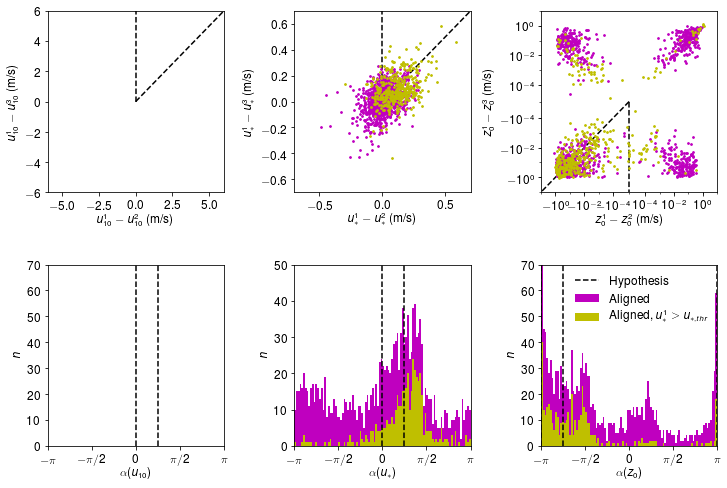

In [40]:
S = 3
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = 0
v6 = 0.7

lpu1 = 0
hpu1 = 25

u2max = 6
usthr = 0.3
usmax = 0.7
znmax = 10
znmin = 10**-5
au2max = 70
ausmax = 50
aznmax = 70

fig = plt.gcf()

ax1 = plt.subplot(231)

# sc = ax1.scatter(u21a-u22a,u21a-u23a,s=S,c='m',label='Aligned')

sc1 = ax1.plot([0,u2max],[0,u2max],'--',c='k',zorder=-1)
sc1 = ax1.plot([0,0],[0,u2max],'--',c='k',label='Hypothesis',zorder=-1)

ax1.set_xlabel('$u_{10}^{1}-u_{10}^{2}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{10}^{1}-u_{10}^{3}$ (m/s)',fontsize=fs)

plt.xlim(-u2max,u2max)
plt.ylim(-u2max,u2max)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(234)

# t1 = ax1.hist(au2resa,bins=100,range=[-np.pi,np.pi],color='m',label='Aligned')

sc1 = ax1.plot([0,0],[0,au2max],'--',c='k')
sc1 = ax1.plot([np.pi/4,np.pi/4],[0,au2max],'--',c='k',label='Hypothesis')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xticks(np.linspace(-np.pi,np.pi,5), ('$-\\pi$', '$-\\pi/2$', '0', '$\\pi/2$', '$\\pi$'))

plt.xlim(-np.pi,np.pi)
plt.ylim(0,au2max)

ax1.set_xlabel('$\\alpha(u_{10})$',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1 = plt.subplot(232)

sc = ax1.scatter(us1ar[us1ar<=usthr]-us2ar[us1ar<=usthr],us1ar[us1ar<=usthr]-us3ar[us1ar<=usthr],s=S,c='m',label='Aligned, $u_{*}^{1}<u_{*,thr}$')
sc = ax1.scatter(us1ar[us1ar>usthr]-us2ar[us1ar>usthr],us1ar[us1ar>usthr]-us3ar[us1ar>usthr],s=S,c='y',label='Aligned, $u_{*}^{1}>u_{*,thr}$')
sc1 = ax1.plot([0,usmax],[0,usmax],'--',c='k',zorder=-1)
sc1 = ax1.plot([0,0],[0,usmax],'--',c='k',label='Hypothesis',zorder=-1)

ax1.set_xlabel('$u_{*}^{1}-u_{*}^{2}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{*}^{1}-u_{*}^{3}$ (m/s)',fontsize=fs)

plt.xlim(-usmax,usmax)
plt.ylim(-usmax,usmax)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(235)

t1 = ax1.hist(ausresar,bins=100,range=[-np.pi,np.pi],color='m',label='Aligned')
t1 = ax1.hist(ausresar[us1ar>usthr],bins=100,range=[-np.pi,np.pi],color='y',label='Aligned, $u_{*}^{1}>u_{*,thr}$')

sc1 = ax1.plot([0,0],[0,ausmax],'--',c='k')
sc1 = ax1.plot([np.pi/4,np.pi/4],[0,ausmax],'--',c='k',label='Hypothesis')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xticks(np.linspace(-np.pi,np.pi,5), ('$-\\pi$', '$-\\pi/2$', '0', '$\\pi/2$', '$\\pi$'))

plt.xlim(-np.pi,np.pi)
plt.ylim(0,ausmax)

ax1.set_xlabel('$\\alpha(u_{*})$',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1 = plt.subplot(233)

sc = ax1.scatter(zn1ar[us1ar<=usthr]-zn2ar[us1ar<=usthr],zn1ar[us1ar<=usthr]-zn3ar[us1ar<=usthr],s=S,c='m',label='Aligned, $u_{*}^{1}<u_{*,thr}$')
sc = ax1.scatter(zn1ar[us1ar>usthr]-zn2ar[us1ar>usthr],zn1ar[us1ar>usthr]-zn3ar[us1ar>usthr],s=S,c='y',label='Aligned, $u_{*}^{1}>u_{*,thr}$')
sc1 = ax1.plot([0,-znmax],[0,-znmax],'--',c='k',zorder=-1)
sc1 = ax1.plot([0,0],[0,-znmax],'--',c='k',label='Hypothesis',zorder=-1)

ax1.set_xlabel('$z_{0}^{1}-z_{0}^{2}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$z_{0}^{1}-z_{0}^{3}$ (m/s)',fontsize=fs)

ax1.set_xscale('symlog', linthreshx=10**-4)
ax1.set_yscale('symlog', linthreshy=10**-4)

plt.xlim(-znmax,znmax)
plt.ylim(-znmax,znmax)

plt.xticks([-10**0,-10**-2,-10**-4,10**-4,10**-2,10**0], ('$-10^{0}$', '$-10^{-2}$', '$-10^{-4}$', '$10^{-4}$', '$10^{-2}$', '$10^{0}$'))
plt.yticks([-10**0,-10**-2,-10**-4,10**-4,10**-2,10**0], ('$-10^{0}$', '$-10^{-2}$', '$-10^{-4}$', '$10^{-4}$', '$10^{-2}$', '$10^{0}$'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(236)

t1 = ax1.hist(aznresar,bins=100,range=[-np.pi,np.pi],color='m',label='Aligned')
t1 = ax1.hist(aznresar[us1ar>usthr],bins=100,range=[-np.pi,np.pi],color='y',label='Aligned, $u_{*}^{1}>u_{*,thr}$')

sc1 = ax1.plot([-3*np.pi/4,-3*np.pi/4],[0,aznmax],'--',c='k')
sc1 = ax1.plot([np.pi,np.pi],[0,aznmax],'--',c='k')
sc1 = ax1.plot([-np.pi,-np.pi],[0,aznmax],'--',c='k',label='Hypothesis')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xticks(np.linspace(-np.pi,np.pi,5), ('$-\\pi$', '$-\\pi/2$', '0', '$\\pi/2$', '$\\pi$'))

plt.xlim(-np.pi,np.pi)
plt.ylim(0,aznmax)

ax1.set_xlabel('$\\alpha(z_{0})$',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1.legend(loc=0,frameon=False,fontsize=fs)

fig.subplots_adjust(wspace=0.4)
fig.subplots_adjust(hspace=0.4)

fig.set_size_inches(12, 8, forward=True)
plt.savefig('some_name8.png', bbox_inches='tight',dpi=300)

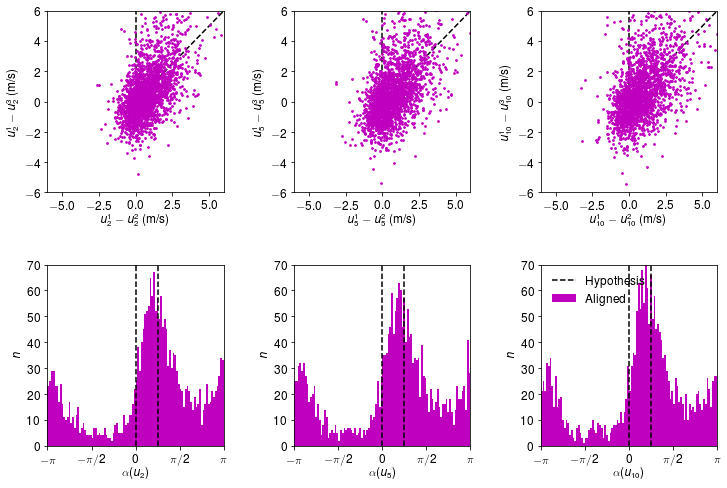

In [18]:
S = 3
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = 0
v6 = 0.7

lpu1 = 0
hpu1 = 25

u0max = 6
au0max = 70
u1max = 6
au1max = 70
u2max = 6
au2max = 70


fig = plt.gcf()

ax1 = plt.subplot(231)

sc = ax1.scatter(u01a-u02a,u01a-u03a,s=S,c='m',label='Aligned')

sc1 = ax1.plot([0,u0max],[0,u0max],'--',c='k',zorder=-1)
sc1 = ax1.plot([0,0],[0,u0max],'--',c='k',label='Hypothesis',zorder=-1)

ax1.set_xlabel('$u_{2}^{1}-u_{2}^{2}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{2}^{1}-u_{2}^{3}$ (m/s)',fontsize=fs)

plt.xlim(-u0max,u0max)
plt.ylim(-u0max,u0max)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(234)

t1 = ax1.hist(au0resa,bins=100,range=[-np.pi,np.pi],color='m',label='Aligned')

sc1 = ax1.plot([0,0],[0,au0max],'--',c='k')
sc1 = ax1.plot([np.pi/4,np.pi/4],[0,au0max],'--',c='k',label='Hypothesis')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xticks(np.linspace(-np.pi,np.pi,5), ('$-\\pi$', '$-\\pi/2$', '0', '$\\pi/2$', '$\\pi$'))

plt.xlim(-np.pi,np.pi)
plt.ylim(0,au0max)

ax1.set_xlabel('$\\alpha(u_{2})$',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1 = plt.subplot(232)

sc = ax1.scatter(u11a-u12a,u11a-u13a,s=S,c='m',label='Aligned')

sc1 = ax1.plot([0,u1max],[0,u1max],'--',c='k',zorder=-1)
sc1 = ax1.plot([0,0],[0,u1max],'--',c='k',label='Hypothesis',zorder=-1)

ax1.set_xlabel('$u_{5}^{1}-u_{5}^{2}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{5}^{1}-u_{5}^{3}$ (m/s)',fontsize=fs)

plt.xlim(-u1max,u1max)
plt.ylim(-u1max,u1max)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(235)

t1 = ax1.hist(au1resa,bins=100,range=[-np.pi,np.pi],color='m',label='Aligned')

sc1 = ax1.plot([0,0],[0,au1max],'--',c='k')
sc1 = ax1.plot([np.pi/4,np.pi/4],[0,au1max],'--',c='k',label='Hypothesis')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xticks(np.linspace(-np.pi,np.pi,5), ('$-\\pi$', '$-\\pi/2$', '0', '$\\pi/2$', '$\\pi$'))

plt.xlim(-np.pi,np.pi)
plt.ylim(0,au1max)

ax1.set_xlabel('$\\alpha(u_{5})$',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1 = plt.subplot(233)

sc = ax1.scatter(u21a-u22a,u21a-u23a,s=S,c='m',label='Aligned')

sc1 = ax1.plot([0,u2max],[0,u2max],'--',c='k',zorder=-1)
sc1 = ax1.plot([0,0],[0,u2max],'--',c='k',label='Hypothesis',zorder=-1)

ax1.set_xlabel('$u_{10}^{1}-u_{10}^{2}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{10}^{1}-u_{10}^{3}$ (m/s)',fontsize=fs)

plt.xlim(-u2max,u2max)
plt.ylim(-u2max,u2max)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(236)

t1 = ax1.hist(au2resa,bins=100,range=[-np.pi,np.pi],color='m',label='Aligned')

sc1 = ax1.plot([0,0],[0,au2max],'--',c='k')
sc1 = ax1.plot([np.pi/4,np.pi/4],[0,au2max],'--',c='k',label='Hypothesis')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xticks(np.linspace(-np.pi,np.pi,5), ('$-\\pi$', '$-\\pi/2$', '0', '$\\pi/2$', '$\\pi$'))

plt.xlim(-np.pi,np.pi)
plt.ylim(0,au2max)

ax1.set_xlabel('$\\alpha(u_{10})$',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1.legend(loc=0,frameon=False,fontsize=fs)

fig.subplots_adjust(wspace=0.4)
fig.subplots_adjust(hspace=0.4)

fig.set_size_inches(12, 8, forward=True)
plt.savefig('some_name2.png', bbox_inches='tight',dpi=300)

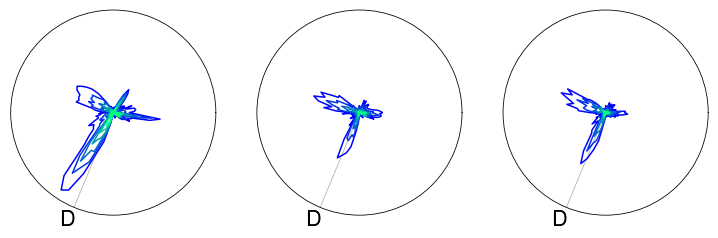

In [66]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here


do = adunes*np.pi/180
resA = 90
resU = 6
ubins = np.linspace(6,10,resU)
hmet1 = []
hmet2 = []
hmet3 = []
c=cm.winter(np.linspace(0,1,resU))

mA = (np.linspace(0,360,resA+1))*np.pi/180

for i in range(0,np.shape(ubins)[0]):
    
    hista1 = np.histogram(a1[u01>ubins[i]],bins=resA,range=(0,360))
    temp1 = np.append(hista1[0],hista1[0][0])
    hmet1.append(temp1)
    
    hista2 = np.histogram(a2[u02>ubins[i]],bins=resA,range=(0,360))
    temp2 = np.append(hista2[0],hista2[0][0])
    hmet2.append(temp2)

    hista3 = np.histogram(a3[u03>ubins[i]],bins=resA,range=(0,360))
    temp3 = np.append(hista3[0],hista3[0][0])
    hmet3.append(temp3)
    
ax = plt.subplot(131,projection='polar')

for i in range(0,np.shape(ubins)[0]):
    sc = ax.plot(mA,hmet1[i],color=c[i])

plt.xticks([do], ('D'))
plt.yticks([],[])
plt.xticks(fontsize=22)
plt.ylim([0,1.1*np.max(hmet1)])

ax = plt.subplot(132,projection='polar')

for i in range(0,np.shape(ubins)[0]):
    sc = ax.plot(mA,hmet2[i],color=c[i])

plt.xticks([do], ('D'))
plt.yticks([],[])
plt.xticks(fontsize=22)
plt.ylim([0,1.1*np.max(hmet1)])

ax = plt.subplot(133,projection='polar')

for i in range(0,np.shape(ubins)[0]):
    sc = ax.plot(mA,hmet3[i],color=c[i])

plt.xticks([do], ('D'))
plt.yticks([],[])
plt.xticks(fontsize=22)
plt.ylim([0,1.1*np.max(hmet1)])

fig = plt.gcf()
fig.set_size_inches(12.5, 4.25, forward=True)
fig.savefig('/home/andrew/Desktop/windroses.png',dpi=100)

In [19]:
############
## LIDAR 2017 ##
############

# to read files
months = range(1,12+1)
days   = range(1,31+1)
part   = range(1,3)

z_l1 = np.asarray([10,13,16,22,28,36,38,46,60,77,300])

t_l1 = [] # icol 2  timestamp [s]
d_l1 = [] #icol 1 DD/MM/YYYY HH:MM:SS

gps_l1 = []
 
u1_l1 = []
u2_l1 = []
u3_l1 = []
u4_l1 = []
u5_l1 = []
u6_l1 = []
u7_l1 = []
u8_l1 = []
u9_l1 = []
u10_l1 = []
u11_l1 = []

a1_l1 = []
a2_l1 = []
a3_l1 = []
a4_l1 = []
a5_l1 = []
a6_l1 = []
a7_l1 = []
a8_l1 = []
a9_l1 = []
a10_l1 = []
a11_l1 = []

for i in months:
    for j in days:
        temp_path = Path(os.getcwd()+'/lidar17_csvs/Wind_320@Y2017_M%02d_D%02d.CSV' % (i,j))
        if temp_path.is_file():
            tempdata = pd.read_csv(temp_path,delimiter=',',header=1)
            
            t_l1.extend(tempdata.iloc[:,2])
            d_l1.extend(pd.to_datetime(tempdata.iloc[:,1]) - pd.Timedelta(hours=2)) #correct timezone from indiana to alamogordo
            
            gps_l1.extend(tempdata.iloc[:,10])
            
            u11_l1.extend(tempdata.iloc[:,20])
            u10_l1.extend(tempdata.iloc[:,23])
            u9_l1.extend(tempdata.iloc[:,26])
            u8_l1.extend(tempdata.iloc[:,29])
            u7_l1.extend(tempdata.iloc[:,32])
            u6_l1.extend(tempdata.iloc[:,35])
            u5_l1.extend(tempdata.iloc[:,38])
            u4_l1.extend(tempdata.iloc[:,41])
            u3_l1.extend(tempdata.iloc[:,44])
            u2_l1.extend(tempdata.iloc[:,47])
            u1_l1.extend(tempdata.iloc[:,50])

            a11_l1.extend(tempdata.iloc[:,19])
            a10_l1.extend(tempdata.iloc[:,22])
            a9_l1.extend(tempdata.iloc[:,25])
            a8_l1.extend(tempdata.iloc[:,28])
            a7_l1.extend(tempdata.iloc[:,31])
            a6_l1.extend(tempdata.iloc[:,34])
            a5_l1.extend(tempdata.iloc[:,37])
            a4_l1.extend(tempdata.iloc[:,40])
            a3_l1.extend(tempdata.iloc[:,43])
            a2_l1.extend(tempdata.iloc[:,46])
            a1_l1.extend(tempdata.iloc[:,49])

        for k in part:
            temp_path = Path(os.getcwd()+'/lidar17_csvs/Wind_320@Y2017_M%02d_D%02d-%d.CSV' % (i,j,k))
            if temp_path.is_file():
                tempdata = pd.read_csv(temp_path,delimiter=',',header=1)
                
                t_l1.extend(tempdata.iloc[:,2])
                d_l1.extend(pd.to_datetime(tempdata.iloc[:,1]) - pd.Timedelta(hours=2)) #correct timezone from indiana to alamogordo
            
                gps_l1.extend(tempdata.iloc[:,10])

                u11_l1.extend(tempdata.iloc[:,20])
                u10_l1.extend(tempdata.iloc[:,23])
                u9_l1.extend(tempdata.iloc[:,26])
                u8_l1.extend(tempdata.iloc[:,29])
                u7_l1.extend(tempdata.iloc[:,32])
                u6_l1.extend(tempdata.iloc[:,35])
                u5_l1.extend(tempdata.iloc[:,38])
                u4_l1.extend(tempdata.iloc[:,41])
                u3_l1.extend(tempdata.iloc[:,44])
                u2_l1.extend(tempdata.iloc[:,47])
                u1_l1.extend(tempdata.iloc[:,50])

                a11_l1.extend(tempdata.iloc[:,19])
                a10_l1.extend(tempdata.iloc[:,22])
                a9_l1.extend(tempdata.iloc[:,25])
                a8_l1.extend(tempdata.iloc[:,28])
                a7_l1.extend(tempdata.iloc[:,31])
                a6_l1.extend(tempdata.iloc[:,34])
                a5_l1.extend(tempdata.iloc[:,37])
                a4_l1.extend(tempdata.iloc[:,40])
                a3_l1.extend(tempdata.iloc[:,43])
                a2_l1.extend(tempdata.iloc[:,46])
                a1_l1.extend(tempdata.iloc[:,49])

t_l1 = np.asarray(t_l1)

gps_l1 = np.asarray(gps_l1)

u1_l1 = np.asarray(u1_l1)
u2_l1 = np.asarray(u2_l1)
u3_l1 = np.asarray(u3_l1)
u4_l1 = np.asarray(u4_l1)
u5_l1 = np.asarray(u5_l1)
u6_l1 = np.asarray(u6_l1)
u7_l1 = np.asarray(u7_l1)
u8_l1 = np.asarray(u8_l1)
u9_l1 = np.asarray(u9_l1)
u10_l1 = np.asarray(u10_l1)
u11_l1 = np.asarray(u11_l1)

a1_l1 = np.asarray(a1_l1)
a2_l1 = np.asarray(a2_l1)
a3_l1 = np.asarray(a3_l1)
a4_l1 = np.asarray(a4_l1)
a5_l1 = np.asarray(a5_l1)
a6_l1 = np.asarray(a6_l1)
a7_l1 = np.asarray(a7_l1)
a8_l1 = np.asarray(a8_l1)
a9_l1 = np.asarray(a9_l1)
a10_l1 = np.asarray(a10_l1)
a11_l1 = np.asarray(a11_l1)

#####

bad_index = np.append(np.argwhere(u1_l1==9999.0),np.argwhere(gps_l1=='#N/A #N/A'))

bad_index = np.append(bad_index,np.argwhere(u2_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u3_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u4_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u5_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u6_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u7_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u8_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u9_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u10_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u11_l1==9999.0))

bad_index = np.append(bad_index,np.argwhere(np.isnan(u1_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u2_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u3_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u4_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u5_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u6_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u7_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u8_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u9_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u10_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u11_l1)))

t_l1 = np.delete(t_l1,bad_index)
d_l1 = np.delete(d_l1,bad_index)

u1_l1 = np.delete(u1_l1,bad_index)
u2_l1 = np.delete(u2_l1,bad_index)
u3_l1 = np.delete(u3_l1,bad_index)
u4_l1 = np.delete(u4_l1,bad_index)
u5_l1 = np.delete(u5_l1,bad_index)
u6_l1 = np.delete(u6_l1,bad_index)
u7_l1 = np.delete(u7_l1,bad_index)
u8_l1 = np.delete(u8_l1,bad_index)
u9_l1 = np.delete(u9_l1,bad_index)
u10_l1 = np.delete(u10_l1,bad_index)
u11_l1 = np.delete(u11_l1,bad_index)

a1_l1 = np.delete(a1_l1,bad_index)
a2_l1 = np.delete(a2_l1,bad_index)
a3_l1 = np.delete(a3_l1,bad_index)
a4_l1 = np.delete(a4_l1,bad_index)
a5_l1 = np.delete(a5_l1,bad_index)
a6_l1 = np.delete(a6_l1,bad_index)
a7_l1 = np.delete(a7_l1,bad_index)
a8_l1 = np.delete(a8_l1,bad_index)
a9_l1 = np.delete(a9_l1,bad_index)
a10_l1 = np.delete(a10_l1,bad_index)
a11_l1 = np.delete(a11_l1,bad_index)

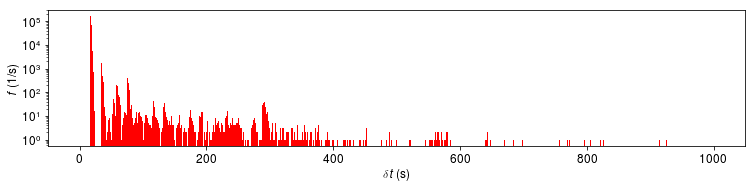

In [20]:
#plot and calculation to show the spread in collection intervals of wind column output from the lidar
#use this cell to find the interpolation timescale to grid the lidar data

longdel_ts_l = 1000 #current arbitrary, should be largest eddy timescale, needs to be int

S = 3
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = 0
v6 = 0.7

fig = plt.gcf()

ax = plt.subplot(111)

ts_l_diff_hist = ax.hist(np.diff(t_l1),bins=longdel_ts_l,range=[0,longdel_ts_l],color='r',log=True)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlabel('$\\delta t$ (s)',fontsize=fs)
plt.ylabel('$f$ (1/s)',fontsize=fs)

fig.set_size_inches(12.5, 2.5, forward=True)

shortdel_ts_l = ts_l_diff_hist[1][np.argmax(ts_l_diff_hist[0])]

In [21]:
# make the lidar data evenly spaced:
#     do this by finding average frequency of raw data (above)
#     use that at this spacing
#     don't want to interpolate across large spans of missing data so
#     find sub series where all the elements are closer than a sufficiently short timescale (largest eddy)
#     then evenly space each of these sub series, append them at the end
#     what interpolation method to use? (int for kind is order of spline 1,2,3 in scipy.interpolate.interp1d)
# this will be useful for: fft, reynolds decomp, cup calibration, comparing days

Tifs_l = np.argwhere(np.diff(t_l1)>longdel_ts_l)
Tiis_l = Tifs_l+1

Tifs_l = np.append(Tifs_l,np.shape(t_l1)[0]-1)
Tiis_l = np.append(0,Tiis_l)

bad_index = []

for i in range(0,np.shape(Tiis_l)[0]):
    if t_l1[Tiis_l[i]]+longdel_ts_l*3 > t_l1[Tifs_l[i]]:
        bad_index = np.append(bad_index,i)
        
Tifs_l = np.delete(Tifs_l,bad_index)
Tiis_l = np.delete(Tiis_l,bad_index)

In [22]:
# grid the lidar (interpolation) data over shortdel_ts_l

spline_order = 1

tg_l1 = [] # icol 2  timestamp [s]
 
u1g_l1 = []
u2g_l1 = []
u3g_l1 = []
u4g_l1 = []
u5g_l1 = []
u6g_l1 = []
u7g_l1 = []
u8g_l1 = []
u9g_l1 = []
u10g_l1 = []
u11g_l1 = []

a1g_l1 = []
a2g_l1 = []
a3g_l1 = []
a4g_l1 = []
a5g_l1 = []
a6g_l1 = []
a7g_l1 = []
a8g_l1 = []
a9g_l1 = []
a10g_l1 = []
a11g_l1 = []

for i in range(0,np.shape(Tiis_l)[0]):
    
    ttemp = np.arange(t_l1[Tiis_l[i]],t_l1[Tifs_l[i]],step=shortdel_ts_l)
    ttemp = ttemp[ttemp<t_l1[Tifs_l[i]]]
    tg_l1 = np.append(tg_l1,ttemp)

    # lidar gridding
    
    fu1_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],u1_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u1temp_l1 = fu1_l1(ttemp)
    u1g_l1 = np.append(u1g_l1,u1temp_l1)
    
    fu2_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],u2_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u2temp_l1 = fu2_l1(ttemp)
    u2g_l1 = np.append(u2g_l1,u2temp_l1)
    
    fu3_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],u3_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u3temp_l1 = fu3_l1(ttemp)
    u3g_l1 = np.append(u3g_l1,u3temp_l1)
    
    fu4_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],u4_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u4temp_l1 = fu4_l1(ttemp)
    u4g_l1 = np.append(u4g_l1,u4temp_l1)
    
    fu5_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],u5_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u5temp_l1 = fu5_l1(ttemp)
    u5g_l1 = np.append(u5g_l1,u5temp_l1)
    
    fu6_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],u6_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u6temp_l1 = fu6_l1(ttemp)
    u6g_l1 = np.append(u6g_l1,u6temp_l1)
    
    fu7_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],u7_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u7temp_l1 = fu7_l1(ttemp)
    u7g_l1 = np.append(u7g_l1,u7temp_l1)
    
    fu8_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],u8_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u8temp_l1 = fu8_l1(ttemp)
    u8g_l1 = np.append(u8g_l1,u8temp_l1)
    
    fu9_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],u9_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u9temp_l1 = fu9_l1(ttemp)
    u9g_l1 = np.append(u9g_l1,u9temp_l1)
    
    fu10_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],u10_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u10temp_l1 = fu10_l1(ttemp)
    u10g_l1 = np.append(u10g_l1,u10temp_l1)
    
    fu11_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],u11_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u11temp_l1 = fu11_l1(ttemp)
    u11g_l1 = np.append(u11g_l1,u11temp_l1)
    
    fa1_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],a1_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a1temp_l1 = fa1_l1(ttemp)
    a1g_l1 = np.append(a1g_l1,a1temp_l1)
    
    fa2_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],a2_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a2temp_l1 = fa2_l1(ttemp)
    a2g_l1 = np.append(a2g_l1,a2temp_l1)
    
    fa3_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],a3_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a3temp_l1 = fa3_l1(ttemp)
    a3g_l1 = np.append(a3g_l1,a3temp_l1)
    
    fa4_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],a4_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a4temp_l1 = fa4_l1(ttemp)
    a4g_l1 = np.append(a4g_l1,a4temp_l1)
    
    fa5_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],a5_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a5temp_l1 = fa5_l1(ttemp)
    a5g_l1 = np.append(a5g_l1,a5temp_l1)
    
    fa6_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],a6_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a6temp_l1 = fa6_l1(ttemp)
    a6g_l1 = np.append(a6g_l1,a6temp_l1)
    
    fa7_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],a7_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a7temp_l1 = fa7_l1(ttemp)
    a7g_l1 = np.append(a7g_l1,a7temp_l1)
    
    fa8_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],a8_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a8temp_l1 = fa8_l1(ttemp)
    a8g_l1 = np.append(a8g_l1,a8temp_l1)
    
    fa9_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],a9_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a9temp_l1 = fa9_l1(ttemp)
    a9g_l1 = np.append(a9g_l1,a9temp_l1)
    
    fa10_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],a10_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a10temp_l1 = fa10_l1(ttemp)
    a10g_l1 = np.append(a10g_l1,a10temp_l1)
    
    fa11_l1 = scipy.interpolate.interp1d(t_l1[Tiis_l[i]:Tifs_l[i]+1],a11_l1[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a11temp_l1 = fa11_l1(ttemp)
    a11g_l1 = np.append(a11g_l1,a11temp_l1)
    
tgd_l1 = tg_l1*s_2_d

In [23]:
#make lidar 10 min smoothed

tdel_ts_m = 10*60

u1gm_l1 = convolve(u1g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u2gm_l1 = convolve(u2g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u3gm_l1 = convolve(u3g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u4gm_l1 = convolve(u4g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u5gm_l1 = convolve(u5g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u6gm_l1 = convolve(u6g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u7gm_l1 = convolve(u7g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u8gm_l1 = convolve(u8g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u9gm_l1 = convolve(u9g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u10gm_l1 = convolve(u10g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u11gm_l1 = convolve(u11g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))

a1gm_l1 = convolve(a1g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a2gm_l1 = convolve(a2g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a3gm_l1 = convolve(a3g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a4gm_l1 = convolve(a4g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a5gm_l1 = convolve(a5g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a6gm_l1 = convolve(a6g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a7gm_l1 = convolve(a7g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a8gm_l1 = convolve(a8g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a9gm_l1 = convolve(a9g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a10gm_l1 = convolve(a10g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a11gm_l1 = convolve(a11g_l1, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))

In [24]:
############
## LIDAR 2018 ##
############

# to read files
months = range(1,12+1)
days   = range(1,31+1)
part   = range(1,3)

z_l2 = np.asarray([10,14,20,28,38,55,78,300])

t_l2 = [] # icol 2  timestamp [s]
d_l2 = [] #icol 1 DD/MM/YYYY HH:MM:SS

gps_l2 = []

u1_l2 = []
u2_l2 = []
u3_l2 = []
u4_l2 = []
u5_l2 = []
u6_l2 = []
u7_l2 = []
u11_l2 = []

a1_l2 = []
a2_l2 = []
a3_l2 = []
a4_l2 = []
a5_l2 = []
a6_l2 = []
a7_l2 = []
a11_l2 = []

for i in months:
    for j in days:
        temp_path = Path(os.getcwd()+'/lidar18_csvs/Wind_320@Y2018_M%02d_D%02d.CSV' % (i,j))
        if temp_path.is_file():
            tempdata = pd.read_csv(temp_path,delimiter=',',header=1)
            
            t_l2.extend(tempdata.iloc[:,2])
            d_l2.extend(pd.to_datetime(tempdata.iloc[:,1]) - pd.Timedelta(hours=2)) #correct timezone from indiana to alamogordo
            
            gps_l2.extend(tempdata.iloc[:,10])
            
            u11_l2.extend(tempdata.iloc[:,20])
            u7_l2.extend(tempdata.iloc[:,32])
            u6_l2.extend(tempdata.iloc[:,35])
            u5_l2.extend(tempdata.iloc[:,38])
            u4_l2.extend(tempdata.iloc[:,41])
            u3_l2.extend(tempdata.iloc[:,44])
            u2_l2.extend(tempdata.iloc[:,47])
            u1_l2.extend(tempdata.iloc[:,50])
            
            a11_l2.extend(tempdata.iloc[:,19])
            a7_l2.extend(tempdata.iloc[:,31])
            a6_l2.extend(tempdata.iloc[:,34])
            a5_l2.extend(tempdata.iloc[:,37])
            a4_l2.extend(tempdata.iloc[:,40])
            a3_l2.extend(tempdata.iloc[:,43])
            a2_l2.extend(tempdata.iloc[:,46])
            a1_l2.extend(tempdata.iloc[:,49])
            
        for k in part:
            temp_path = Path(os.getcwd()+'/lidar18_csvs/Wind_320@Y2018_M%02d_D%02d-%d.CSV' % (i,j,k))
            if temp_path.is_file():
                tempdata = pd.read_csv(temp_path,delimiter=',',header=1)
                
                t_l2.extend(tempdata.iloc[:,2])
                d_l2.extend(pd.to_datetime(tempdata.iloc[:,1]) - pd.Timedelta(hours=2)) #correct timezone from indiana to alamogordo
            
                gps_l2.extend(tempdata.iloc[:,10])

                u11_l2.extend(tempdata.iloc[:,20])
                u7_l2.extend(tempdata.iloc[:,32])
                u6_l2.extend(tempdata.iloc[:,35])
                u5_l2.extend(tempdata.iloc[:,38])
                u4_l2.extend(tempdata.iloc[:,41])
                u3_l2.extend(tempdata.iloc[:,44])
                u2_l2.extend(tempdata.iloc[:,47])
                u1_l2.extend(tempdata.iloc[:,50])

                a11_l2.extend(tempdata.iloc[:,19])
                a7_l2.extend(tempdata.iloc[:,31])
                a6_l2.extend(tempdata.iloc[:,34])
                a5_l2.extend(tempdata.iloc[:,37])
                a4_l2.extend(tempdata.iloc[:,40])
                a3_l2.extend(tempdata.iloc[:,43])
                a2_l2.extend(tempdata.iloc[:,46])
                a1_l2.extend(tempdata.iloc[:,49])


t_l2 = np.asarray(t_l2)

gps_l2 = np.asarray(gps_l2)

u1_l2 = np.asarray(u1_l2)
u2_l2 = np.asarray(u2_l2)
u3_l2 = np.asarray(u3_l2)
u4_l2 = np.asarray(u4_l2)
u5_l2 = np.asarray(u5_l2)
u6_l2 = np.asarray(u6_l2)
u7_l2 = np.asarray(u7_l2)
u11_l2 = np.asarray(u11_l2)

a1_l2 = np.asarray(a1_l2)
a2_l2 = np.asarray(a2_l2)
a3_l2 = np.asarray(a3_l2)
a4_l2 = np.asarray(a4_l2)
a5_l2 = np.asarray(a5_l2)
a6_l2 = np.asarray(a6_l2)
a7_l2 = np.asarray(a7_l2)
a11_l2 = np.asarray(a11_l2)

#####

bad_index = np.append(np.argwhere(u1_l2==9999.0),np.argwhere(gps_l2=='#N/A #N/A'))

bad_index = np.append(bad_index,np.argwhere(u2_l2==9999.0))
bad_index = np.append(bad_index,np.argwhere(u3_l2==9999.0))
bad_index = np.append(bad_index,np.argwhere(u4_l2==9999.0))
bad_index = np.append(bad_index,np.argwhere(u5_l2==9999.0))
bad_index = np.append(bad_index,np.argwhere(u6_l2==9999.0))
bad_index = np.append(bad_index,np.argwhere(u7_l2==9999.0))
bad_index = np.append(bad_index,np.argwhere(u11_l2==9999.0))

bad_index = np.append(bad_index,np.argwhere(np.isnan(u1_l2)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u2_l2)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u3_l2)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u4_l2)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u5_l2)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u6_l2)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u7_l2)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u11_l2)))

t_l2 = np.delete(t_l2,bad_index)
d_l2 = np.delete(d_l2,bad_index)

u1_l2 = np.delete(u1_l2,bad_index)
u2_l2 = np.delete(u2_l2,bad_index)
u3_l2 = np.delete(u3_l2,bad_index)
u4_l2 = np.delete(u4_l2,bad_index)
u5_l2 = np.delete(u5_l2,bad_index)
u6_l2 = np.delete(u6_l2,bad_index)
u7_l2 = np.delete(u7_l2,bad_index)
u11_l2 = np.delete(u11_l2,bad_index)

a1_l2 = np.delete(a1_l2,bad_index)
a2_l2 = np.delete(a2_l2,bad_index)
a3_l2 = np.delete(a3_l2,bad_index)
a4_l2 = np.delete(a4_l2,bad_index)
a5_l2 = np.delete(a5_l2,bad_index)
a6_l2 = np.delete(a6_l2,bad_index)
a7_l2 = np.delete(a7_l2,bad_index)
a11_l2 = np.delete(a11_l2,bad_index)

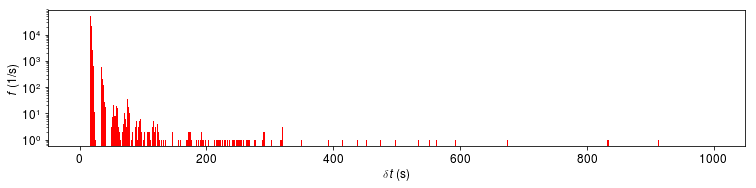

In [25]:
#plot and calculation to show the spread in collection intervals of wind column output from the lidar
#use this cell to find the interpolation timescale to grid the lidar data

longdel_ts_l = 1000 #current arbitrary, should be largest eddy timescale, needs to be int

S = 3
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = 0
v6 = 0.7

fig = plt.gcf()

ax = plt.subplot(111)

ts_l_diff_hist = ax.hist(np.diff(t_l2),bins=longdel_ts_l,range=[0,longdel_ts_l],color='r',log=True)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlabel('$\\delta t$ (s)',fontsize=fs)
plt.ylabel('$f$ (1/s)',fontsize=fs)

fig.set_size_inches(12.5, 2.5, forward=True)

shortdel_ts_l = ts_l_diff_hist[1][np.argmax(ts_l_diff_hist[0])]

In [26]:
# make the lidar data evenly spaced:
#     do this by finding average frequency of raw data (above)
#     use that at this spacing
#     don't want to interpolate across large spans of missing data so
#     find sub series where all the elements are closer than a sufficiently short timescale (largest eddy)
#     then evenly space each of these sub series, append them at the end
#     what interpolation method to use? (int for kind is order of spline 1,2,3 in scipy.interpolate.interp1d)
# this will be useful for: fft, reynolds decomp, cup calibration, comparing days

Tifs_l = np.argwhere(np.diff(t_l2)>longdel_ts_l)
Tiis_l = Tifs_l+1

Tifs_l = np.append(Tifs_l,np.shape(t_l2)[0]-1)
Tiis_l = np.append(0,Tiis_l)

bad_index = []

for i in range(0,np.shape(Tiis_l)[0]):
    if t_l2[Tiis_l[i]]+longdel_ts_l*3 > t_l2[Tifs_l[i]]:
        bad_index = np.append(bad_index,i)
        
Tifs_l = np.delete(Tifs_l,bad_index)
Tiis_l = np.delete(Tiis_l,bad_index)

In [27]:
# grid the lidar (interpolation) data over shortdel_ts_l

spline_order = 1

tg_l2 = [] # icol 2  timestamp [s]
 
u1g_l2 = []
u2g_l2 = []
u3g_l2 = []
u4g_l2 = []
u5g_l2 = []
u6g_l2 = []
u7g_l2 = []
u11g_l2 = []

a1g_l2 = []
a2g_l2 = []
a3g_l2 = []
a4g_l2 = []
a5g_l2 = []
a6g_l2 = []
a7g_l2 = []
a11g_l2 = []

for i in range(0,np.shape(Tiis_l)[0]):
    
    ttemp = np.arange(t_l2[Tiis_l[i]],t_l2[Tifs_l[i]],step=shortdel_ts_l)
    ttemp = ttemp[ttemp<t_l2[Tifs_l[i]]]
    tg_l2 = np.append(tg_l2,ttemp)

    # lidar gridding
    
    fu1_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],u1_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u1temp_l2 = fu1_l2(ttemp)
    u1g_l2 = np.append(u1g_l2,u1temp_l2)
    
    fu2_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],u2_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u2temp_l2 = fu2_l2(ttemp)
    u2g_l2 = np.append(u2g_l2,u2temp_l2)
    
    fu3_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],u3_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u3temp_l2 = fu3_l2(ttemp)
    u3g_l2 = np.append(u3g_l2,u3temp_l2)
    
    fu4_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],u4_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u4temp_l2 = fu4_l2(ttemp)
    u4g_l2 = np.append(u4g_l2,u4temp_l2)
    
    fu5_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],u5_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u5temp_l2 = fu5_l2(ttemp)
    u5g_l2 = np.append(u5g_l2,u5temp_l2)
    
    fu6_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],u6_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u6temp_l2 = fu6_l2(ttemp)
    u6g_l2 = np.append(u6g_l2,u6temp_l2)
    
    fu7_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],u7_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u7temp_l2 = fu7_l2(ttemp)
    u7g_l2 = np.append(u7g_l2,u7temp_l2)
    
    fu11_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],u11_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u11temp_l2 = fu11_l2(ttemp)
    u11g_l2 = np.append(u11g_l2,u11temp_l2)
    
    fa1_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],a1_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a1temp_l2 = fa1_l2(ttemp)
    a1g_l2 = np.append(a1g_l2,a1temp_l2)
    
    fa2_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],a2_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a2temp_l2 = fa2_l2(ttemp)
    a2g_l2 = np.append(a2g_l2,a2temp_l2)
    
    fa3_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],a3_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a3temp_l2 = fa3_l2(ttemp)
    a3g_l2 = np.append(a3g_l2,a3temp_l2)
    
    fa4_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],a4_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a4temp_l2 = fa4_l2(ttemp)
    a4g_l2 = np.append(a4g_l2,a4temp_l2)
    
    fa5_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],a5_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a5temp_l2 = fa5_l2(ttemp)
    a5g_l2 = np.append(a5g_l2,a5temp_l2)
    
    fa6_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],a6_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a6temp_l2 = fa6_l2(ttemp)
    a6g_l2 = np.append(a6g_l2,a6temp_l2)
    
    fa7_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],a7_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a7temp_l2 = fa7_l2(ttemp)
    a7g_l2 = np.append(a7g_l2,a7temp_l2)
        
    fa11_l2 = scipy.interpolate.interp1d(t_l2[Tiis_l[i]:Tifs_l[i]+1],a11_l2[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    a11temp_l2 = fa11_l2(ttemp)
    a11g_l2 = np.append(a11g_l2,a11temp_l2)
    
tgd_l2 = tg_l2*s_2_d

In [28]:
#make lidar 10 min smoothed

tdel_ts_m = 10*60

u1gm_l2 = convolve(u1g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u2gm_l2 = convolve(u2g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u3gm_l2 = convolve(u3g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u4gm_l2 = convolve(u4g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u5gm_l2 = convolve(u5g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u6gm_l2 = convolve(u6g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u7gm_l2 = convolve(u7g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u11gm_l2 = convolve(u11g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))

a1gm_l2 = convolve(a1g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a2gm_l2 = convolve(a2g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a3gm_l2 = convolve(a3g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a4gm_l2 = convolve(a4g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a5gm_l2 = convolve(a5g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a6gm_l2 = convolve(a6g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a7gm_l2 = convolve(a7g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
a11gm_l2 = convolve(a11g_l2, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))

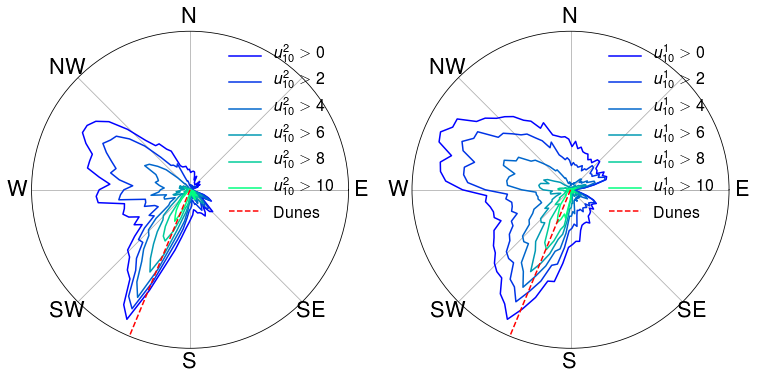

In [39]:
do = adunes*np.pi/180
resA = 90
resU = 6
ubins = np.linspace(0,10,resU)
ha1 = []
ha0 = []
c=cm.winter(np.linspace(0,1,resU))

mA = (np.linspace(0,360,resA+1))*np.pi/180

for i in range(0,np.shape(ubins)[0]):
    
    hista1 = np.histogram(a1gm_l2[u1gm_l2>ubins[i]],bins=resA,range=(0,360))
    temp1 = np.append(hista1[0],hista1[0][0])
    ha1.append(temp1)
    
    hista0 = np.histogram(a1gm_l1[u1gm_l1>ubins[i]],bins=resA,range=(0,360))
    temp0 = np.append(hista0[0],hista0[0][0])
    ha0.append(temp0)

ax = plt.subplot(121,projection='polar')

for i in range(0,np.shape(ubins)[0]):
    sc = ax.plot(mA,ha1[i],color=c[i],label='$u_{10}^2> %d$'%ubins[i])
sc = ax.plot([do,do],[0,1.1*np.max(ha1)],'--',c='r',label='Dunes')

plt.xticks(2*np.pi*np.linspace(0,1,9), ('E','','N','NW','W','SW','S','SE'))
plt.yticks([],[])
plt.xticks(fontsize=22)
plt.ylim([0,1.1*np.max(ha1)])

ax.legend(loc=1,frameon=False,fontsize=16)

ax = plt.subplot(122,projection='polar')

for i in range(0,np.shape(ubins)[0]):
    sc = ax.plot(mA,ha0[i],color=c[i],label='$u_{10}^1> %d$'%ubins[i])
sc = ax.plot([do,do],[0,1.1*np.max(ha0)],'--',c='r',label='Dunes')

plt.xticks(2*np.pi*np.linspace(0,1,9), ('E','','N','NW','W','SW','S','SE'))
plt.yticks([],[])
plt.xticks(fontsize=22)
plt.ylim([0,1.1*np.max(ha0)])

ax.legend(loc=1,frameon=False,fontsize=16)

fig = plt.gcf()
fig.set_size_inches(12.5, 6.5, forward=True)
fig.savefig('/home/andrew/Desktop/windroses.pdf',dpi=300)

In [30]:
u1gm_l1at = []
u2gm_l1at = []
u3gm_l1at = []
u4gm_l1at = []
u5gm_l1at = []
u6gm_l1at = []
u7gm_l1at = []
u8gm_l1at = []
u9gm_l1at = []
u10gm_l1at = []
u11gm_l1at = []

a1gm_l1at = []
a2gm_l1at = []
a3gm_l1at = []
a4gm_l1at = []
a5gm_l1at = []
a6gm_l1at = []
a7gm_l1at = []
a8gm_l1at = []
a9gm_l1at = []
a10gm_l1at = []
a11gm_l1at = []

u1gm_l2at = []
u2gm_l2at = []
u3gm_l2at = []
u4gm_l2at = []
u5gm_l2at = []
u6gm_l2at = []
u7gm_l2at = []
u11gm_l2at = []

a1gm_l2at = []
a2gm_l2at = []
a3gm_l2at = []
a4gm_l2at = []
a5gm_l2at = []
a6gm_l2at = []
a7gm_l2at = []
a11gm_l2at = []

u1gm_l1ab = []
u2gm_l1ab = []
u3gm_l1ab = []
u4gm_l1ab = []
u5gm_l1ab = []
u6gm_l1ab = []
u7gm_l1ab = []
u8gm_l1ab = []
u9gm_l1ab = []
u10gm_l1ab = []
u11gm_l1ab = []

a1gm_l1ab = []
a2gm_l1ab = []
a3gm_l1ab = []
a4gm_l1ab = []
a5gm_l1ab = []
a6gm_l1ab = []
a7gm_l1ab = []
a8gm_l1ab = []
a9gm_l1ab = []
a10gm_l1ab = []
a11gm_l1ab = []

u1gm_l2ab = []
u2gm_l2ab = []
u3gm_l2ab = []
u4gm_l2ab = []
u5gm_l2ab = []
u6gm_l2ab = []
u7gm_l2ab = []
u11gm_l2ab = []

a1gm_l2ab = []
a2gm_l2ab = []
a3gm_l2ab = []
a4gm_l2ab = []
a5gm_l2ab = []
a6gm_l2ab = []
a7gm_l2ab = []
a11gm_l2ab = []

for i in range(0,np.shape(tg_l1)[0]):
    if (a11gm_l1[i]<adunes+adelta) & (a11gm_l1[i]>adunes-adelta):
        
        u1gm_l1at = np.append(u1gm_l1at,u1gm_l1[i])
        u2gm_l1at = np.append(u2gm_l1at,u2gm_l1[i])
        u3gm_l1at = np.append(u3gm_l1at,u3gm_l1[i])
        u4gm_l1at = np.append(u4gm_l1at,u4gm_l1[i])
        u5gm_l1at = np.append(u5gm_l1at,u5gm_l1[i])
        u6gm_l1at = np.append(u6gm_l1at,u6gm_l1[i])
        u7gm_l1at = np.append(u7gm_l1at,u7gm_l1[i])
        u8gm_l1at = np.append(u8gm_l1at,u8gm_l1[i])
        u9gm_l1at = np.append(u9gm_l1at,u9gm_l1[i])
        u10gm_l1at = np.append(u10gm_l1at,u10gm_l1[i])
        u11gm_l1at = np.append(u11gm_l1at,u11gm_l1[i])

        a1gm_l1at = np.append(a1gm_l1at,a1gm_l1[i])
        a2gm_l1at = np.append(a2gm_l1at,a2gm_l1[i])
        a3gm_l1at = np.append(a3gm_l1at,a3gm_l1[i])
        a4gm_l1at = np.append(a4gm_l1at,a4gm_l1[i])
        a5gm_l1at = np.append(a5gm_l1at,a5gm_l1[i])
        a6gm_l1at = np.append(a6gm_l1at,a6gm_l1[i])
        a7gm_l1at = np.append(a7gm_l1at,a7gm_l1[i])
        a8gm_l1at = np.append(a8gm_l1at,a8gm_l1[i])
        a9gm_l1at = np.append(a9gm_l1at,a9gm_l1[i])
        a10gm_l1at = np.append(a10gm_l1at,a10gm_l1[i])
        a11gm_l1at = np.append(a11gm_l1at,a11gm_l1[i])
        
    if (a1gm_l1[i]<adunes+adelta) & (a1gm_l1[i]>adunes-adelta):
        
        u1gm_l1ab = np.append(u1gm_l1ab,u1gm_l1[i])
        u2gm_l1ab = np.append(u2gm_l1ab,u2gm_l1[i])
        u3gm_l1ab = np.append(u3gm_l1ab,u3gm_l1[i])
        u4gm_l1ab = np.append(u4gm_l1ab,u4gm_l1[i])
        u5gm_l1ab = np.append(u5gm_l1ab,u5gm_l1[i])
        u6gm_l1ab = np.append(u6gm_l1ab,u6gm_l1[i])
        u7gm_l1ab = np.append(u7gm_l1ab,u7gm_l1[i])
        u8gm_l1ab = np.append(u8gm_l1ab,u8gm_l1[i])
        u9gm_l1ab = np.append(u9gm_l1ab,u9gm_l1[i])
        u10gm_l1ab = np.append(u10gm_l1ab,u10gm_l1[i])
        u11gm_l1ab = np.append(u11gm_l1ab,u11gm_l1[i])

        a1gm_l1ab = np.append(a1gm_l1ab,a1gm_l1[i])
        a2gm_l1ab = np.append(a2gm_l1ab,a2gm_l1[i])
        a3gm_l1ab = np.append(a3gm_l1ab,a3gm_l1[i])
        a4gm_l1ab = np.append(a4gm_l1ab,a4gm_l1[i])
        a5gm_l1ab = np.append(a5gm_l1ab,a5gm_l1[i])
        a6gm_l1ab = np.append(a6gm_l1ab,a6gm_l1[i])
        a7gm_l1ab = np.append(a7gm_l1ab,a7gm_l1[i])
        a8gm_l1ab = np.append(a8gm_l1ab,a8gm_l1[i])
        a9gm_l1ab = np.append(a9gm_l1ab,a9gm_l1[i])
        a10gm_l1ab = np.append(a10gm_l1ab,a10gm_l1[i])
        a11gm_l1ab = np.append(a11gm_l1ab,a11gm_l1[i])

        
for i in range(0,np.shape(tg_l2)[0]):
    if (a11gm_l2[i]<adunes+adelta) & (a11gm_l2[i]>adunes-adelta):
        
        u1gm_l2at = np.append(u1gm_l2at,u1gm_l2[i])
        u2gm_l2at = np.append(u2gm_l2at,u2gm_l2[i])
        u3gm_l2at = np.append(u3gm_l2at,u3gm_l2[i])
        u4gm_l2at = np.append(u4gm_l2at,u4gm_l2[i])
        u5gm_l2at = np.append(u5gm_l2at,u5gm_l2[i])
        u6gm_l2at = np.append(u6gm_l2at,u6gm_l2[i])
        u7gm_l2at = np.append(u7gm_l2at,u7gm_l2[i])
        u11gm_l2at = np.append(u11gm_l2at,u11gm_l2[i])

        a1gm_l2at = np.append(a1gm_l2at,a1gm_l2[i])
        a2gm_l2at = np.append(a2gm_l2at,a2gm_l2[i])
        a3gm_l2at = np.append(a3gm_l2at,a3gm_l2[i])
        a4gm_l2at = np.append(a4gm_l2at,a4gm_l2[i])
        a5gm_l2at = np.append(a5gm_l2at,a5gm_l2[i])
        a6gm_l2at = np.append(a6gm_l2at,a6gm_l2[i])
        a7gm_l2at = np.append(a7gm_l2at,a7gm_l2[i])
        a11gm_l2at = np.append(a11gm_l2at,a11gm_l2[i])
            
    if (a1gm_l2[i]<adunes+adelta) & (a1gm_l2[i]>adunes-adelta):
        
        u1gm_l2ab = np.append(u1gm_l2ab,u1gm_l2[i])
        u2gm_l2ab = np.append(u2gm_l2ab,u2gm_l2[i])
        u3gm_l2ab = np.append(u3gm_l2ab,u3gm_l2[i])
        u4gm_l2ab = np.append(u4gm_l2ab,u4gm_l2[i])
        u5gm_l2ab = np.append(u5gm_l2ab,u5gm_l2[i])
        u6gm_l2ab = np.append(u6gm_l2ab,u6gm_l2[i])
        u7gm_l2ab = np.append(u7gm_l2ab,u7gm_l2[i])
        u11gm_l2ab = np.append(u11gm_l2ab,u11gm_l2[i])

        a1gm_l2ab = np.append(a1gm_l2ab,a1gm_l2[i])
        a2gm_l2ab = np.append(a2gm_l2ab,a2gm_l2[i])
        a3gm_l2ab = np.append(a3gm_l2ab,a3gm_l2[i])
        a4gm_l2ab = np.append(a4gm_l2ab,a4gm_l2[i])
        a5gm_l2ab = np.append(a5gm_l2ab,a5gm_l2[i])
        a6gm_l2ab = np.append(a6gm_l2ab,a6gm_l2[i])
        a7gm_l2ab = np.append(a7gm_l2ab,a7gm_l2[i])
        a11gm_l2ab = np.append(a11gm_l2ab,a11gm_l2[i])


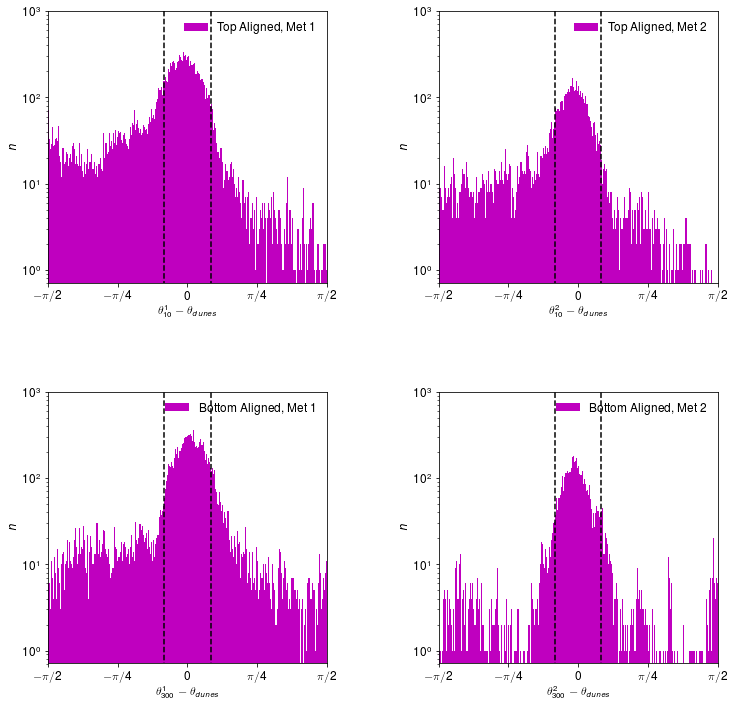

In [31]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 3
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = 0
v6 = 0.7

lpu1 = 0
hpu1 = 25

amax = 10**3


fig = plt.gcf()

ax1 = plt.subplot(221)

t1 = ax1.hist((a1gm_l1at-adunes)*np.pi/180,bins=10**3,range=[-np.pi/2,np.pi/2],color='m',log=True,label='Top Aligned, Met 1')

sc1 = ax1.plot([-adelta*np.pi/180,-adelta*np.pi/180],[0,amax],'--',c='k')
sc1 = ax1.plot([adelta*np.pi/180,adelta*np.pi/180],[0,amax],'--',c='k')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xticks(np.linspace(-np.pi/2,np.pi/2,5), ('$-\\pi/2$', '$-\\pi/4$', '0', '$\\pi/4$', '$\\pi/2$'))

plt.xlim(-np.pi/2,np.pi/2)
plt.ylim(0,amax)

ax1.set_xlabel('$\\theta_{10}^1-\\theta_{dunes}$',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1.legend(loc=0,frameon=False,fontsize=fs)

ax1 = plt.subplot(222)

t1 = ax1.hist((a1gm_l2at-adunes)*np.pi/180,bins=10**3,range=[-np.pi/2,np.pi/2],color='m',log=True,label='Top Aligned, Met 2')

sc1 = ax1.plot([-adelta*np.pi/180,-adelta*np.pi/180],[0,amax],'--',c='k')
sc1 = ax1.plot([adelta*np.pi/180,adelta*np.pi/180],[0,amax],'--',c='k')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xticks(np.linspace(-np.pi/2,np.pi/2,5), ('$-\\pi/2$', '$-\\pi/4$', '0', '$\\pi/4$', '$\\pi/2$'))

plt.xlim(-np.pi/2,np.pi/2)
plt.ylim(0,amax)

ax1.set_xlabel('$\\theta_{10}^2-\\theta_{dunes}$',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1.legend(loc=0,frameon=False,fontsize=fs)

ax1 = plt.subplot(223)

t1 = ax1.hist((a11gm_l1ab-adunes)*np.pi/180,bins=10**3,range=[-np.pi/2,np.pi/2],color='m',log=True,label='Bottom Aligned, Met 1')

sc1 = ax1.plot([-adelta*np.pi/180,-adelta*np.pi/180],[0,amax],'--',c='k')
sc1 = ax1.plot([adelta*np.pi/180,adelta*np.pi/180],[0,amax],'--',c='k')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xticks(np.linspace(-np.pi/2,np.pi/2,5), ('$-\\pi/2$', '$-\\pi/4$', '0', '$\\pi/4$', '$\\pi/2$'))

plt.xlim(-np.pi/2,np.pi/2)
plt.ylim(0,amax)

ax1.set_xlabel('$\\theta_{300}^1-\\theta_{dunes}$',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1.legend(loc=0,frameon=False,fontsize=fs)

ax1 = plt.subplot(224)

t1 = ax1.hist((a11gm_l2ab-adunes)*np.pi/180,bins=10**3,range=[-np.pi/2,np.pi/2],color='m',log=True,label='Bottom Aligned, Met 2')

sc1 = ax1.plot([-adelta*np.pi/180,-adelta*np.pi/180],[0,amax],'--',c='k')
sc1 = ax1.plot([adelta*np.pi/180,adelta*np.pi/180],[0,amax],'--',c='k')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xticks(np.linspace(-np.pi/2,np.pi/2,5), ('$-\\pi/2$', '$-\\pi/4$', '0', '$\\pi/4$', '$\\pi/2$'))

plt.xlim(-np.pi/2,np.pi/2)
plt.ylim(0,amax)

ax1.set_xlabel('$\\theta_{300}^2-\\theta_{dunes}$',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1.legend(loc=0,frameon=False,fontsize=fs)

fig.subplots_adjust(wspace=0.4)
fig.subplots_adjust(hspace=0.4)

fig.set_size_inches(12, 12, forward=True)
plt.savefig('some_name3.png', bbox_inches='tight',dpi=300)

In [32]:
ugm_l1ab = [u1gm_l1ab, u2gm_l1ab, u3gm_l1ab, u4gm_l1ab, u5gm_l1ab, u6gm_l1ab, u7gm_l1ab, u8gm_l1ab, u9gm_l1ab, u10gm_l1ab]
ugm_l1ab_scaled = [u1gm_l1ab, u2gm_l1ab, u3gm_l1ab, u4gm_l1ab, u5gm_l1ab, u6gm_l1ab, u7gm_l1ab, u8gm_l1ab, u9gm_l1ab, u10gm_l1ab]/u1gm_l1ab

Ugm_l1ab = np.mean(ugm_l1ab,axis=1)
Ugm25_l1ab = np.percentile(ugm_l1ab,25,axis=1)
Ugm75_l1ab = np.percentile(ugm_l1ab,75,axis=1)

Ugm_l1ab_scaled = np.mean(ugm_l1ab_scaled,axis=1)
Ugm25_l1ab_scaled = np.percentile(ugm_l1ab_scaled,25,axis=1)
Ugm75_l1ab_scaled = np.percentile(ugm_l1ab_scaled,75,axis=1)

ugm_l2ab = [u1gm_l2ab, u2gm_l2ab, u3gm_l2ab, u4gm_l2ab, u5gm_l2ab, u6gm_l2ab, u7gm_l2ab]
ugm_l2ab_scaled = [u1gm_l2ab, u2gm_l2ab, u3gm_l2ab, u4gm_l2ab, u5gm_l2ab, u6gm_l2ab, u7gm_l2ab]/u1gm_l2ab

Ugm_l2ab = np.mean(ugm_l2ab,axis=1)
Ugm25_l2ab = np.percentile(ugm_l2ab,25,axis=1)
Ugm75_l2ab = np.percentile(ugm_l2ab,75,axis=1)

Ugm_l2ab_scaled = np.mean(ugm_l2ab_scaled,axis=1)
Ugm25_l2ab_scaled = np.percentile(ugm_l2ab_scaled,25,axis=1)
Ugm75_l2ab_scaled = np.percentile(ugm_l2ab_scaled,75,axis=1)

In [33]:
ugm_l1at = [u1gm_l1at, u2gm_l1at, u3gm_l1at, u4gm_l1at, u5gm_l1at, u6gm_l1at, u7gm_l1at, u8gm_l1at, u9gm_l1at, u10gm_l1at]
ugm_l1at_scaled = [u1gm_l1at, u2gm_l1at, u3gm_l1at, u4gm_l1at, u5gm_l1at, u6gm_l1at, u7gm_l1at, u8gm_l1at, u9gm_l1at, u10gm_l1at]/u11gm_l1at

Ugm_l1at = np.mean(ugm_l1at,axis=1)
Ugm25_l1at = np.percentile(ugm_l1at,25,axis=1)
Ugm75_l1at = np.percentile(ugm_l1at,75,axis=1)

Ugm_l1at_scaled = np.mean(ugm_l1at_scaled,axis=1)
Ugm25_l1at_scaled = np.percentile(ugm_l1at_scaled,25,axis=1)
Ugm75_l1at_scaled = np.percentile(ugm_l1at_scaled,75,axis=1)

ugm_l2at = [u1gm_l2at, u2gm_l2at, u3gm_l2at, u4gm_l2at, u5gm_l2at, u6gm_l2at, u7gm_l2at]
ugm_l2at_scaled = [u1gm_l2at, u2gm_l2at, u3gm_l2at, u4gm_l2at, u5gm_l2at, u6gm_l2at, u7gm_l2at]/u11gm_l2at

Ugm_l2at = np.mean(ugm_l2at,axis=1)
Ugm25_l2at = np.percentile(ugm_l2at,25,axis=1)
Ugm75_l2at = np.percentile(ugm_l2at,75,axis=1)

Ugm_l2at_scaled = np.mean(ugm_l2at_scaled,axis=1)
Ugm25_l2at_scaled = np.percentile(ugm_l2at_scaled,25,axis=1)
Ugm75_l2at_scaled = np.percentile(ugm_l2at_scaled,75,axis=1)

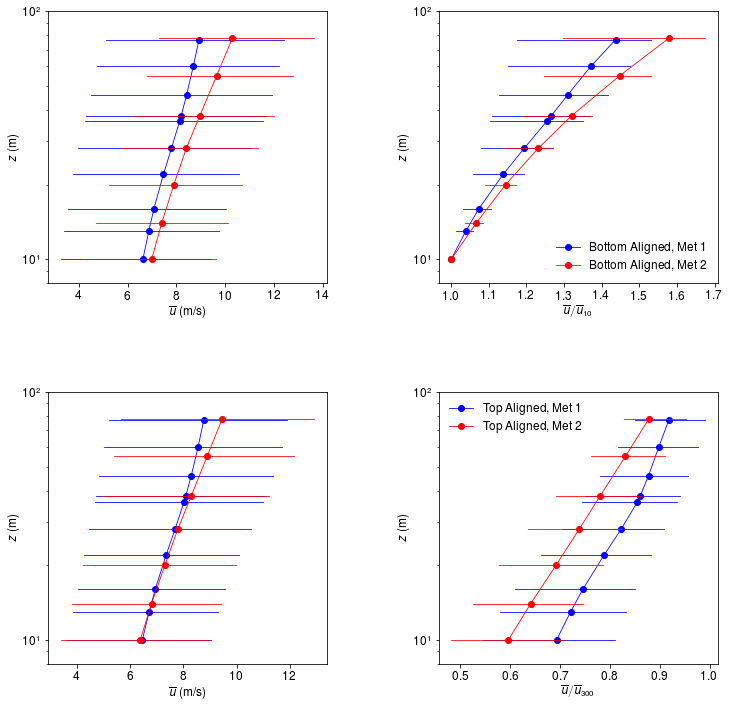

In [34]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 3
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = 0
v6 = 0.7

lpu1 = 0
hpu1 = 25

fig = plt.gcf()

ax1 = plt.subplot(221)

sc1 = ax1.plot(Ugm_l1ab,z_l1[:-1],'-o',lw=LW,c='b',label='Bottom Aligned, Met 1')
for i in np.arange(0,np.shape(z_l1[:-1])[0]):
    sc2 = ax1.plot([Ugm25_l1ab[i],Ugm75_l1ab[i]],[z_l1[i],z_l1[i]],lw=LW,c='b')
    
sc1 = ax1.plot(Ugm_l2ab,z_l2[:-1],'-o',lw=LW,c='r',label='Bottom Aligned, Met 2')
for i in np.arange(0,np.shape(z_l2[:-1])[0]):
    sc2 = ax1.plot([Ugm25_l2ab[i],Ugm75_l2ab[i]],[z_l2[i],z_l2[i]],lw=LW,c='r')
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylim(8,100)

ax1.set_yscale('log')

ax1.set_xlabel('$\\overline{u}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$z$ (m)',fontsize=fs)

ax1 = plt.subplot(222)

sc1 = ax1.plot(Ugm_l1ab_scaled,z_l1[:-1],'-o',lw=LW,c='b',label='Bottom Aligned, Met 1')
for i in np.arange(0,np.shape(z_l1[:-1])[0]):
    sc2 = ax1.plot([Ugm25_l1ab_scaled[i],Ugm75_l1ab_scaled[i]],[z_l1[i],z_l1[i]],lw=LW,c='b')
    
sc1 = ax1.plot(Ugm_l2ab_scaled,z_l2[:-1],'-o',lw=LW,c='r',label='Bottom Aligned, Met 2')
for i in np.arange(0,np.shape(z_l2[:-1])[0]):
    sc2 = ax1.plot([Ugm25_l2ab_scaled[i],Ugm75_l2ab_scaled[i]],[z_l2[i],z_l2[i]],lw=LW,c='r')
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylim(8,100)

ax1.set_yscale('log')

ax1.set_xlabel('$\\overline{u}/\\overline{u}_{10}$',fontsize=fs)
ax1.set_ylabel('$z$ (m)',fontsize=fs)

ax1.legend(loc=0,frameon=False,fontsize=fs)

ax1 = plt.subplot(223)

sc1 = ax1.plot(Ugm_l1at,z_l1[:-1],'-o',lw=LW,c='b',label='Top Aligned, Met 1')
for i in np.arange(0,np.shape(z_l1[:-1])[0]):
    sc2 = ax1.plot([Ugm25_l1at[i],Ugm75_l1at[i]],[z_l1[i],z_l1[i]],lw=LW,c='b')
    
sc1 = ax1.plot(Ugm_l2at,z_l2[:-1],'-o',lw=LW,c='r',label='Top Aligned, Met 2')
for i in np.arange(0,np.shape(z_l2[:-1])[0]):
    sc2 = ax1.plot([Ugm25_l2at[i],Ugm75_l2at[i]],[z_l2[i],z_l2[i]],lw=LW,c='r')
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylim(8,100)

ax1.set_yscale('log')

ax1.set_xlabel('$\\overline{u}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$z$ (m)',fontsize=fs)

ax1 = plt.subplot(224)

sc1 = ax1.plot(Ugm_l1at_scaled,z_l1[:-1],'-o',lw=LW,c='b',label='Top Aligned, Met 1')
for i in np.arange(0,np.shape(z_l1[:-1])[0]):
    sc2 = ax1.plot([Ugm25_l1at_scaled[i],Ugm75_l1at_scaled[i]],[z_l1[i],z_l1[i]],lw=LW,c='b')
    
sc1 = ax1.plot(Ugm_l2at_scaled,z_l2[:-1],'-o',lw=LW,c='r',label='Top Aligned, Met 2')
for i in np.arange(0,np.shape(z_l2[:-1])[0]):
    sc2 = ax1.plot([Ugm25_l2at_scaled[i],Ugm75_l2at_scaled[i]],[z_l2[i],z_l2[i]],lw=LW,c='r')
    
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylim(8,100)

ax1.set_yscale('log')

ax1.set_xlabel('$\\overline{u}/\\overline{u}_{300}$',fontsize=fs)
ax1.set_ylabel('$z$ (m)',fontsize=fs)

ax1.legend(loc=0,frameon=False,fontsize=fs)

fig.subplots_adjust(wspace=0.4)
fig.subplots_adjust(hspace=0.4)

fig.set_size_inches(12, 12, forward=True)
plt.savefig('some_name4.png', bbox_inches='tight',dpi=300)

In [35]:
u1gm_lab_bins = np.linspace(0,20,100)
u1gm_lab_binned = u1gm_lab_bins[:-1]+np.diff(u1gm_lab_bins)

u1gm_l1ab_binned = []
u2gm_l1ab_binned = []
u3gm_l1ab_binned = []
u4gm_l1ab_binned = []
u5gm_l1ab_binned = []
u6gm_l1ab_binned = []
u7gm_l1ab_binned = []
u8gm_l1ab_binned = []
u9gm_l1ab_binned = []
u10gm_l1ab_binned = []
u11gm_l1ab_binned = []

a1gm_l1ab_binned = []
a2gm_l1ab_binned = []
a3gm_l1ab_binned = []
a4gm_l1ab_binned = []
a5gm_l1ab_binned = []
a6gm_l1ab_binned = []
a7gm_l1ab_binned = []
a8gm_l1ab_binned = []
a9gm_l1ab_binned = []
a10gm_l1ab_binned = []
a11gm_l1ab_binned = []

u1gm_l2ab_binned = []
u2gm_l2ab_binned = []
u3gm_l2ab_binned = []
u4gm_l2ab_binned = []
u5gm_l2ab_binned = []
u6gm_l2ab_binned = []
u7gm_l2ab_binned = []
u11gm_l2ab_binned = []

a1gm_l2ab_binned = []
a2gm_l2ab_binned = []
a3gm_l2ab_binned = []
a4gm_l2ab_binned = []
a5gm_l2ab_binned = []
a6gm_l2ab_binned = []
a7gm_l2ab_binned = []
a11gm_l2ab_binned = []

for i in np.arange(0,np.shape(u1gm_lab_bins)[0]-1):
    tempind_l1 = np.argwhere((u1gm_l1ab>u1gm_lab_bins[i])&(u1gm_l1ab<=u1gm_lab_bins[i+1]))
    u1gm_l1ab_binned = np.append(u1gm_l1ab_binned,np.mean(u1gm_l1ab[tempind_l1]))
    u2gm_l1ab_binned = np.append(u2gm_l1ab_binned,np.mean(u2gm_l1ab[tempind_l1]))
    u3gm_l1ab_binned = np.append(u3gm_l1ab_binned,np.mean(u3gm_l1ab[tempind_l1]))
    u4gm_l1ab_binned = np.append(u4gm_l1ab_binned,np.mean(u4gm_l1ab[tempind_l1]))
    u5gm_l1ab_binned = np.append(u5gm_l1ab_binned,np.mean(u5gm_l1ab[tempind_l1]))
    u6gm_l1ab_binned = np.append(u6gm_l1ab_binned,np.mean(u6gm_l1ab[tempind_l1]))
    u7gm_l1ab_binned = np.append(u7gm_l1ab_binned,np.mean(u7gm_l1ab[tempind_l1]))
    u8gm_l1ab_binned = np.append(u8gm_l1ab_binned,np.mean(u8gm_l1ab[tempind_l1]))
    u9gm_l1ab_binned = np.append(u9gm_l1ab_binned,np.mean(u9gm_l1ab[tempind_l1]))
    u10gm_l1ab_binned = np.append(u10gm_l1ab_binned,np.mean(u10gm_l1ab[tempind_l1]))
    u11gm_l1ab_binned = np.append(u11gm_l1ab_binned,np.mean(u11gm_l1ab[tempind_l1]))
    
    a1gm_l1ab_binned = np.append(a1gm_l1ab_binned,np.mean(a1gm_l1ab[tempind_l1]))
    a2gm_l1ab_binned = np.append(a2gm_l1ab_binned,np.mean(a2gm_l1ab[tempind_l1]))
    a3gm_l1ab_binned = np.append(a3gm_l1ab_binned,np.mean(a3gm_l1ab[tempind_l1]))
    a4gm_l1ab_binned = np.append(a4gm_l1ab_binned,np.mean(a4gm_l1ab[tempind_l1]))
    a5gm_l1ab_binned = np.append(a5gm_l1ab_binned,np.mean(a5gm_l1ab[tempind_l1]))
    a6gm_l1ab_binned = np.append(a6gm_l1ab_binned,np.mean(a6gm_l1ab[tempind_l1]))
    a7gm_l1ab_binned = np.append(a7gm_l1ab_binned,np.mean(a7gm_l1ab[tempind_l1]))
    a8gm_l1ab_binned = np.append(a8gm_l1ab_binned,np.mean(a8gm_l1ab[tempind_l1]))
    a9gm_l1ab_binned = np.append(a9gm_l1ab_binned,np.mean(a9gm_l1ab[tempind_l1]))
    a10gm_l1ab_binned = np.append(a10gm_l1ab_binned,np.mean(a10gm_l1ab[tempind_l1]))
    a11gm_l1ab_binned = np.append(a11gm_l1ab_binned,np.mean(a11gm_l1ab[tempind_l1]))
    
    tempind_l2 = np.argwhere((u1gm_l2ab>u1gm_lab_bins[i])&(u1gm_l2ab<=u1gm_lab_bins[i+1]))
    u1gm_l2ab_binned = np.append(u1gm_l2ab_binned,np.mean(u1gm_l2ab[tempind_l2]))
    u2gm_l2ab_binned = np.append(u2gm_l2ab_binned,np.mean(u2gm_l2ab[tempind_l2]))
    u3gm_l2ab_binned = np.append(u3gm_l2ab_binned,np.mean(u3gm_l2ab[tempind_l2]))
    u4gm_l2ab_binned = np.append(u4gm_l2ab_binned,np.mean(u4gm_l2ab[tempind_l2]))
    u5gm_l2ab_binned = np.append(u5gm_l2ab_binned,np.mean(u5gm_l2ab[tempind_l2]))
    u6gm_l2ab_binned = np.append(u6gm_l2ab_binned,np.mean(u6gm_l2ab[tempind_l2]))
    u7gm_l2ab_binned = np.append(u7gm_l2ab_binned,np.mean(u7gm_l2ab[tempind_l2]))
    u11gm_l2ab_binned = np.append(u11gm_l2ab_binned,np.mean(u11gm_l2ab[tempind_l2]))
    
    a1gm_l2ab_binned = np.append(a1gm_l2ab_binned,np.mean(a1gm_l2ab[tempind_l2]))
    a2gm_l2ab_binned = np.append(a2gm_l2ab_binned,np.mean(a2gm_l2ab[tempind_l2]))
    a3gm_l2ab_binned = np.append(a3gm_l2ab_binned,np.mean(a3gm_l2ab[tempind_l2]))
    a4gm_l2ab_binned = np.append(a4gm_l2ab_binned,np.mean(a4gm_l2ab[tempind_l2]))
    a5gm_l2ab_binned = np.append(a5gm_l2ab_binned,np.mean(a5gm_l2ab[tempind_l2]))
    a6gm_l2ab_binned = np.append(a6gm_l2ab_binned,np.mean(a6gm_l2ab[tempind_l2]))
    a7gm_l2ab_binned = np.append(a7gm_l2ab_binned,np.mean(a7gm_l2ab[tempind_l2]))
    a11gm_l2ab_binned = np.append(a11gm_l2ab_binned,np.mean(a11gm_l2ab[tempind_l2]))

In [36]:
u11gm_lat_bins = np.linspace(0,30,100)
u11gm_lat_binned = u11gm_lat_bins[:-1]+np.diff(u11gm_lat_bins)

u1gm_l1at_binned = []
u2gm_l1at_binned = []
u3gm_l1at_binned = []
u4gm_l1at_binned = []
u5gm_l1at_binned = []
u6gm_l1at_binned = []
u7gm_l1at_binned = []
u8gm_l1at_binned = []
u9gm_l1at_binned = []
u10gm_l1at_binned = []
u11gm_l1at_binned = []

a1gm_l1at_binned = []
a2gm_l1at_binned = []
a3gm_l1at_binned = []
a4gm_l1at_binned = []
a5gm_l1at_binned = []
a6gm_l1at_binned = []
a7gm_l1at_binned = []
a8gm_l1at_binned = []
a9gm_l1at_binned = []
a10gm_l1at_binned = []
a11gm_l1at_binned = []

u1gm_l2at_binned = []
u2gm_l2at_binned = []
u3gm_l2at_binned = []
u4gm_l2at_binned = []
u5gm_l2at_binned = []
u6gm_l2at_binned = []
u7gm_l2at_binned = []
u11gm_l2at_binned = []

a1gm_l2at_binned = []
a2gm_l2at_binned = []
a3gm_l2at_binned = []
a4gm_l2at_binned = []
a5gm_l2at_binned = []
a6gm_l2at_binned = []
a7gm_l2at_binned = []
a11gm_l2at_binned = []

for i in np.arange(0,np.shape(u11gm_lat_bins)[0]-1):
    tempind_l1 = np.argwhere((u11gm_l1at>u11gm_lat_bins[i])&(u11gm_l1at<=u11gm_lat_bins[i+1]))
    u1gm_l1at_binned = np.append(u1gm_l1at_binned,np.mean(u1gm_l1at[tempind_l1]))
    u2gm_l1at_binned = np.append(u2gm_l1at_binned,np.mean(u2gm_l1at[tempind_l1]))
    u3gm_l1at_binned = np.append(u3gm_l1at_binned,np.mean(u3gm_l1at[tempind_l1]))
    u4gm_l1at_binned = np.append(u4gm_l1at_binned,np.mean(u4gm_l1at[tempind_l1]))
    u5gm_l1at_binned = np.append(u5gm_l1at_binned,np.mean(u5gm_l1at[tempind_l1]))
    u6gm_l1at_binned = np.append(u6gm_l1at_binned,np.mean(u6gm_l1at[tempind_l1]))
    u7gm_l1at_binned = np.append(u7gm_l1at_binned,np.mean(u7gm_l1at[tempind_l1]))
    u8gm_l1at_binned = np.append(u8gm_l1at_binned,np.mean(u8gm_l1at[tempind_l1]))
    u9gm_l1at_binned = np.append(u9gm_l1at_binned,np.mean(u9gm_l1at[tempind_l1]))
    u10gm_l1at_binned = np.append(u10gm_l1at_binned,np.mean(u10gm_l1at[tempind_l1]))
    u11gm_l1at_binned = np.append(u11gm_l1at_binned,np.mean(u11gm_l1at[tempind_l1]))
    
    a1gm_l1at_binned = np.append(a1gm_l1at_binned,np.mean(a1gm_l1at[tempind_l1]))
    a2gm_l1at_binned = np.append(a2gm_l1at_binned,np.mean(a2gm_l1at[tempind_l1]))
    a3gm_l1at_binned = np.append(a3gm_l1at_binned,np.mean(a3gm_l1at[tempind_l1]))
    a4gm_l1at_binned = np.append(a4gm_l1at_binned,np.mean(a4gm_l1at[tempind_l1]))
    a5gm_l1at_binned = np.append(a5gm_l1at_binned,np.mean(a5gm_l1at[tempind_l1]))
    a6gm_l1at_binned = np.append(a6gm_l1at_binned,np.mean(a6gm_l1at[tempind_l1]))
    a7gm_l1at_binned = np.append(a7gm_l1at_binned,np.mean(a7gm_l1at[tempind_l1]))
    a8gm_l1at_binned = np.append(a8gm_l1at_binned,np.mean(a8gm_l1at[tempind_l1]))
    a9gm_l1at_binned = np.append(a9gm_l1at_binned,np.mean(a9gm_l1at[tempind_l1]))
    a10gm_l1at_binned = np.append(a10gm_l1at_binned,np.mean(a10gm_l1at[tempind_l1]))
    a11gm_l1at_binned = np.append(a11gm_l1at_binned,np.mean(a11gm_l1at[tempind_l1]))
    
    tempind_l2 = np.argwhere((u11gm_l2at>u11gm_lat_bins[i])&(u11gm_l2at<=u11gm_lat_bins[i+1]))
    u1gm_l2at_binned = np.append(u1gm_l2at_binned,np.mean(u1gm_l2at[tempind_l2]))
    u2gm_l2at_binned = np.append(u2gm_l2at_binned,np.mean(u2gm_l2at[tempind_l2]))
    u3gm_l2at_binned = np.append(u3gm_l2at_binned,np.mean(u3gm_l2at[tempind_l2]))
    u4gm_l2at_binned = np.append(u4gm_l2at_binned,np.mean(u4gm_l2at[tempind_l2]))
    u5gm_l2at_binned = np.append(u5gm_l2at_binned,np.mean(u5gm_l2at[tempind_l2]))
    u6gm_l2at_binned = np.append(u6gm_l2at_binned,np.mean(u6gm_l2at[tempind_l2]))
    u7gm_l2at_binned = np.append(u7gm_l2at_binned,np.mean(u7gm_l2at[tempind_l2]))
    u11gm_l2at_binned = np.append(u11gm_l2at_binned,np.mean(u11gm_l2at[tempind_l2]))
    
    a1gm_l2at_binned = np.append(a1gm_l2at_binned,np.mean(a1gm_l2at[tempind_l2]))
    a2gm_l2at_binned = np.append(a2gm_l2at_binned,np.mean(a2gm_l2at[tempind_l2]))
    a3gm_l2at_binned = np.append(a3gm_l2at_binned,np.mean(a3gm_l2at[tempind_l2]))
    a4gm_l2at_binned = np.append(a4gm_l2at_binned,np.mean(a4gm_l2at[tempind_l2]))
    a5gm_l2at_binned = np.append(a5gm_l2at_binned,np.mean(a5gm_l2at[tempind_l2]))
    a6gm_l2at_binned = np.append(a6gm_l2at_binned,np.mean(a6gm_l2at[tempind_l2]))
    a7gm_l2at_binned = np.append(a7gm_l2at_binned,np.mean(a7gm_l2at[tempind_l2]))
    a11gm_l2at_binned = np.append(a11gm_l2at_binned,np.mean(a11gm_l2at[tempind_l2]))

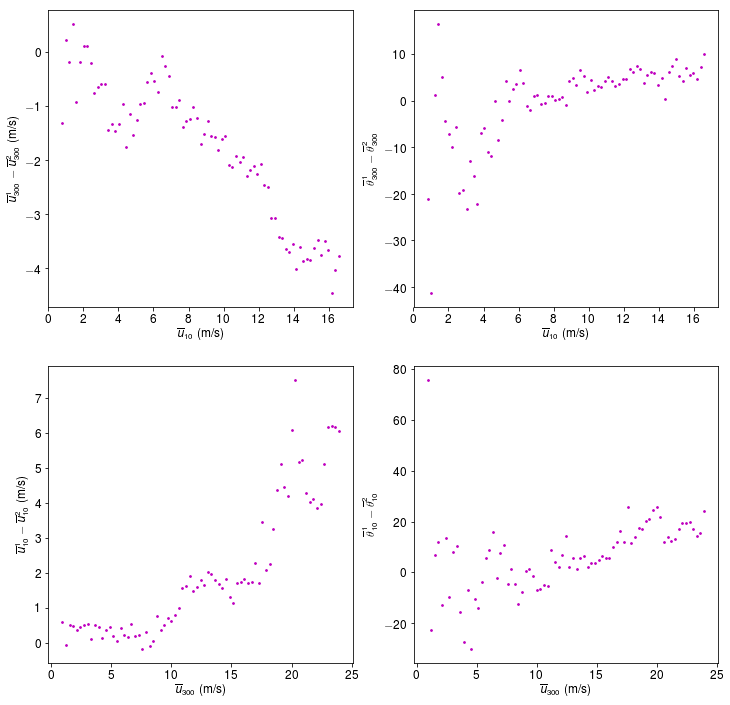

In [37]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 3
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = 0
v6 = 0.7

lpu1 = 0
hpu1 = 25

fig = plt.gcf()

ax1 = plt.subplot(221)

sc1 = ax1.scatter(u1gm_lab_binned,u11gm_l1ab_binned-u11gm_l2ab_binned,s=S,c='m')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1.set_xlabel('$\\overline{u}_{10}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$\\overline{u}_{300}^1-\\overline{u}_{300}^2$ (m/s)',fontsize=fs)

ax1 = plt.subplot(222)

sc1 = ax1.scatter(u1gm_lab_binned,a11gm_l1ab_binned-a11gm_l2ab_binned,s=S,c='m')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1.set_xlabel('$\\overline{u}_{10}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$\\overline{\\theta}_{300}^1-\\overline{\\theta}_{300}^2$',fontsize=fs)

ax1 = plt.subplot(223)

sc1 = ax1.scatter(u11gm_lat_binned,u1gm_l1at_binned-u1gm_l2at_binned,s=S,c='m')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1.set_xlabel('$\\overline{u}_{300}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$\\overline{u}_{10}^1-\\overline{u}_{10}^2$ (m/s)',fontsize=fs)

ax1 = plt.subplot(224)

sc1 = ax1.scatter(u11gm_lat_binned,a1gm_l1at_binned-a1gm_l2at_binned,s=S,c='m')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1.set_xlabel('$\\overline{u}_{300}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$\\overline{\\theta}_{10}^1-\\overline{\\theta}_{10}^2$',fontsize=fs)

fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.2)

fig.set_size_inches(12, 12, forward=True)
plt.savefig('some_name5.png', bbox_inches='tight',dpi=300)